## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Histogram of Oriented Gradients (HOG)

**1. HOG features.**

I started by reading in all the `vehicle` and `non-vehicle` images. I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Two example images using the `YCrCb` color space (Luma channel) and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)` are shown as output of the following code cells.

**2. Choice of HOG parameters.**

`YCrCb` was chosen as the color space since it gave a better SVM test accuracy than other color spaces considered including RGB, HLS, HSV etc. The number of `orientations` were chosen as suggested in literature and no direct benefit was observed in increasing it beyond this number. The `pixels_per_cell` and `cells_per_block` were set to the default values as used in the lessons as they gave decent classification accuracy and besides that their values seem appropriate for 64x64 training images.

In [1]:
# this code cell loads the 'car' and 'not car' images from directories

import os
import glob
basedir = 'vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
	cars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of Vehicle Images found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of Non-Vehicle Images found:', len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


In [2]:
import time
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
# computes and returns hog features for given set of parameters    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img,size=(32,32)):
# returns concatenated spatial features of each channel after resizing    
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1,color2,color3))

def color_hist(img, nbins=32):
# returns concatenated histograms of each channel      
    ch1_hist = np.histogram(img[:,:,0], bins=nbins)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    return hist_features

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, 
                     hog_channel=0, spatial_feat=True,hist_feat=True,hog_feat=True, horLen=(), lenBool=False):
# reads multiple images and extracts a selection of spatial, histogram and hog features     
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'Composite':
                ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                feature_image = np.stack((ycrcb[:,:,0],yuv[:,:,1],hls[:,:,2]),axis=2)                
        else: 
            feature_image = np.copy(image)      
        
        spatial_features = []
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        hist_features = []
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        hog_features = []
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)   
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block,vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
        horLen = (len(spatial_features),len(hist_features),len(hog_features))
    
    if lenBool == False:
        return features
    else:
        return features, horLen

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
# returns a list of overlapping windows    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
# draws bounding boxes on an image    
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img

def single_image_features(image, cspace='RGB', spatial_size=(32, 32),hist_bins=32, 
                          orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                          spatial_feat=True,hist_feat=True, hog_feat=True, vis=False, horlen=(), lenBool=False):
# extracts a selection of spatial, histogram and hog features from a single image
    img_features = []
    if cspace != 'RGB' and cspace != 'Composite':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'Composite':
            ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            feature_image = np.stack((ycrcb[:,:,0],yuv[:,:,1],hls[:,:,2]),axis=2)    
    else: 
        feature_image = np.copy(image)      
    
    spatial_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    hist_features = []
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    
    hog_features = []
    if hog_feat == True:
        if hog_channel == 'ALL':            
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)	
             
        img_features.append(hog_features)
    
    horLen = (len(spatial_features),len(hist_features),len(hog_features))
    
    if vis == True and lenBool == False:
        return np.concatenate(img_features), hog_image
    elif vis == False and lenBool == True:
        return np.concatenate(img_features), horLen
    elif vis == True and lenBool == True:
        return np.concatenate(img_features), hog_image, horLen
    else:
        return np.concatenate(img_features)
        
def search_windows(img, windows, clf, scaler, color_space='RGB',decision_thresh=0.1, 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
# performs a search over sliding windows using a trained classifier and returns matching windows
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_image_features(test_img, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        decision = clf.decision_function(test_features)
        
        if decision > decision_thresh:
            on_windows.append(window)
    return on_windows

def visualize(gif, rows, cols, imgs, titles):
# plots images in a list     
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3 :
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
                      

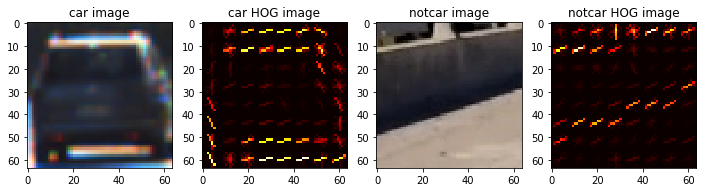

In [4]:
# this code cell computes spatial, histogram and hog features for a random image and visualizes hog features

%matplotlib inline

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (32, 32)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_image_features(car_image, cspace=color_space, spatial_size=spatial_size,
                                                    hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_image_features(notcar_image, cspace=color_space, spatial_size=spatial_size,
                                                    hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)


images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles=['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)



**3. Training a classifier**

I trained a linear SVM using spatial, histogram and HOG features from all channels of the `YCrCb` color space. This gave me a feature vector of size 8412 for each image. The hog features store shape information, the color histograms stores color information while raw spatial features store both color and shape information in images. The feature vectors were scaled to unit variance and zero mean before training to avoid comparing 'apples to oranges'. The detailed parameter choices are printed in the output of the following code cells alongwith the training time and final test accuracy. A linear SVM was chosen (although a GridSearchCV with a RBF kernel was also tried) because of its reduced tendency to overfit the training data.    

In [5]:
# this code cell computes feature vector for all images in training set and trains a linear SVM classifier

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
test_cars = cars          
test_notcars = notcars       

car_features, horLen = extract_features(test_cars, cspace=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,lenBool=True)

notcar_features = extract_features(test_notcars, cspace=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features ...')


X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,'pixels per cell,', cell_per_block,
	  'cells per block,',hist_bins,'histogram bins, and', spatial_size,'spatial sampling')
print('Feature vector length: ', len(X_train[0]))
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)

print(round(time.time()-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

59.259804487228394 Seconds to compute features ...
Using: 9 orientations, 8 pixels per cell, 2 cells per block, 16 histogram bins, and (32, 32) spatial sampling
Feature vector length:  8412
23.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9944


## Sliding Window Search

**1. Scale of search and size of overlap?**

Two slightly different algorithms for sliding window search have been implemented in the below code cells. The first algorithm contained in the procedures `search_windows` and `slide_window` consists of extracting overlapping windows of a particular size (96,96) with a overlap of 50% and then finding composite feature vectors for each window. The linear SVM then gives a prediction for each window and those windows in which the decision function is greater than 0 (this is a binary classification case) are returned. A fixed scale corresponding to a window size of 96 was chosen as it gives good detections near the horizon and nice tight_fit detections in general. A multi-scale approach was experimented with but was not pursued further as the computation time suffered greatly with multiple scales since the number of windows to search increase exponentially - detections at larger scale could be achieved with this fixed scale by labeling regions of overlapping detections (generating a heat map).

In order to optimize the search process another algorithm was implemented which was a variation of the first algorithm but with computational savings - this is evident from the fact that it takes less time to search more windows than the first algorithm as shown in the outputs. The optimized search algorithm scaled down the image and computed hog features only once for a region of interest where vehicle detection is probable as compared to the first algorithm which computed hog features independently for each window. Each window was assigned hog features appropriately from the already computed hog features. 

**2. Optimization of pipeline?**

Examples of test images are shown in the following code cells. The decision function was thresholded so that false positives are rejected to a certain extent. To reject false positives further, a heat map of detections was generated by labeling regions of overlapping detections using `scipy.ndimage.measurements.label()`. In addition, this heatmap was thresholded to only include regions with `2` overlapping detected windows. The results based on heat maps is also visualized subsequently. 

0.3959646224975586 seconds to process one image searching 100 windows
0.33849024772644043 seconds to process one image searching 100 windows
0.3199183940887451 seconds to process one image searching 100 windows
0.3190193176269531 seconds to process one image searching 100 windows
0.32144689559936523 seconds to process one image searching 100 windows
0.31094932556152344 seconds to process one image searching 100 windows


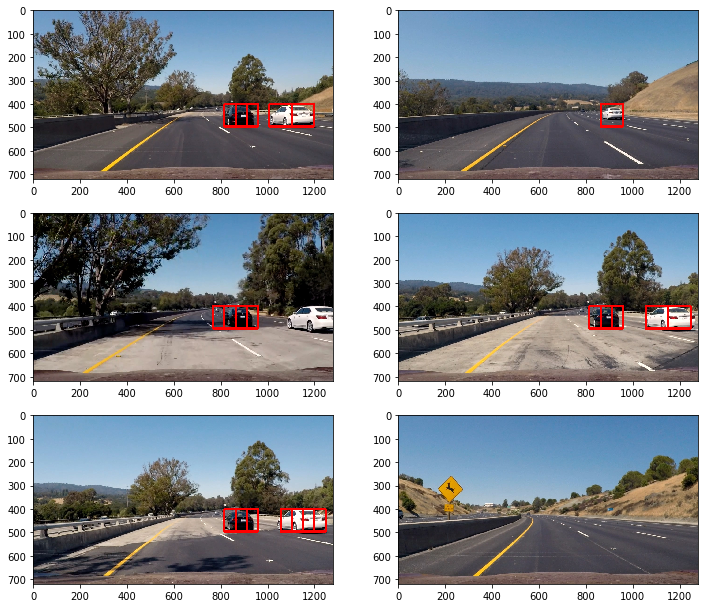

In [6]:
# this code cell implements the first sliding window search algorithm

searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656] 
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop = y_start_stop,
                           xy_window=(96,96), xy_overlap=(overlap, overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat,hog_feat=hog_feat)

    window_img = draw_boxes(draw_img, hot_windows, color=(255,0,0), thick=8)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')
fig = plt.figure(figsize=(12,18))
visualize(fig, 5, 2, images, titles)

In [7]:
def convert_color(img, conv='RGB2YCrCb'):
#converts color spaces from RGB    
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

0.27415943145751953 seconds to run, total windows =  294
0.256641149520874 seconds to run, total windows =  294
0.25882768630981445 seconds to run, total windows =  294
0.2652580738067627 seconds to run, total windows =  294
0.26287341117858887 seconds to run, total windows =  294
0.26027774810791016 seconds to run, total windows =  294


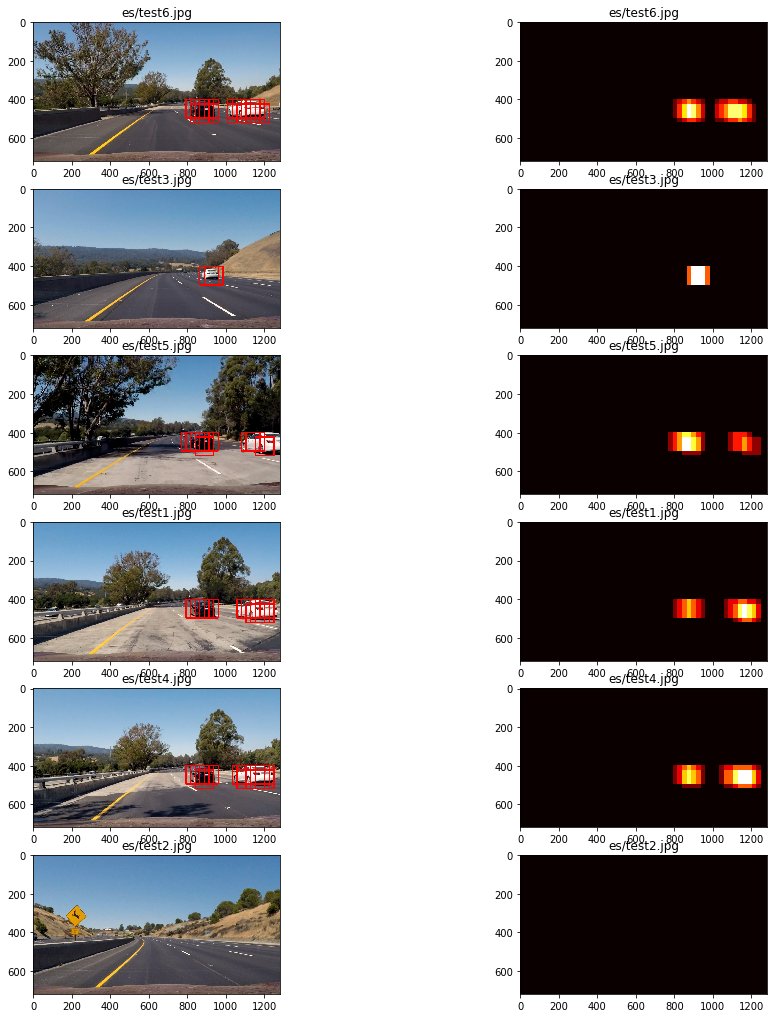

In [8]:
# this code cell implements the second optimized sliding window search algorithm

out_images = []
out_maps = []
out_titles = []
out_boxes = []
ystart = 400
ystop = 656
scale = 1.5
window = 64

for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float32)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')  
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    nblocks_per_window = window // pix_per_cell - cell_per_block + 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos= yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_decision = svc.decision_function(test_features)
            
            if test_decision > 0.1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    print(time.time()-t,'seconds to run, total windows = ', count)
            
    out_images.append(draw_img)
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize=(16,24))
visualize(fig, 8, 2, out_images, out_titles)

In [9]:
def find_cars(img, scale=1, cell_per_block = 2, pix_per_cell=8, cells_per_step=2, orient=9, window=64,decision_thresh=0.1, 
              spatial_size = (32,32), hist_bins = 16, x_start_stop=[None, None], y_start_stop=[None, None]):
# implements optimized search algorithm for given set of parameters and generates a heat map

    x_start = x_start_stop[0]
    x_stop = x_start_stop[1]
    y_start = y_start_stop[0]
    y_start = y_start_stop[1]
    
    if x_start_stop[0] == None:
        x_start = 0
    if x_start_stop[1] == None:
        x_stop = img.shape[1]
    if y_start_stop[0] == None:
        y_start = 0
    if y_start_stop[1] == None:
        y_start = img.shape[0] 
        
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float32)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    nblocks_per_window = window // pix_per_cell - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos= yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_decision = svc.decision_function(test_features)
            
            if test_decision > decision_thresh:        
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0))
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    return draw_img, heatmap

In [10]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
# applies threshold to heatmap    
    heatmap[heatmap < threshold] = 0
    return heatmap

def draw_labeled_boxes(img,labels,box_size=16):
# draws size filtered bounding boxes based on region labels    
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if np.max(nonzerox) - np.min(nonzerox) > box_size and np.max(nonzeroy) - np.min(nonzeroy) > box_size:
            bbox = ((np.min(nonzerox),np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))	
            cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    return img

def find_box_centroids(labels,M,offset=0.25,box_size=16):
# returns normal centroids and transformed centroids of size filtered bounding boxes    
    box_centroids = []
    warped_box_centroids = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if np.max(nonzerox) - np.min(nonzerox) > box_size and np.max(nonzeroy) - np.min(nonzeroy) > box_size:
            centroid = [(np.min(nonzerox)+np.max(nonzerox))//2,
                        int(offset*(np.max(nonzeroy)-np.min(nonzeroy))) + (np.min(nonzeroy)+np.max(nonzeroy))//2]
            box_centroids.append(centroid)
            print(box_centroids)
            warped_centroid = cv2.transform(np.array([[centroid]],dtype='float32'), M).ravel()
            warped_centroid = ((warped_centroid[0:2]/warped_centroid[2]).astype(np.int32)).tolist()
            warped_box_centroids.append(warped_centroid)
            print(warped_box_centroids)
        
    return box_centroids, warped_box_centroids
     

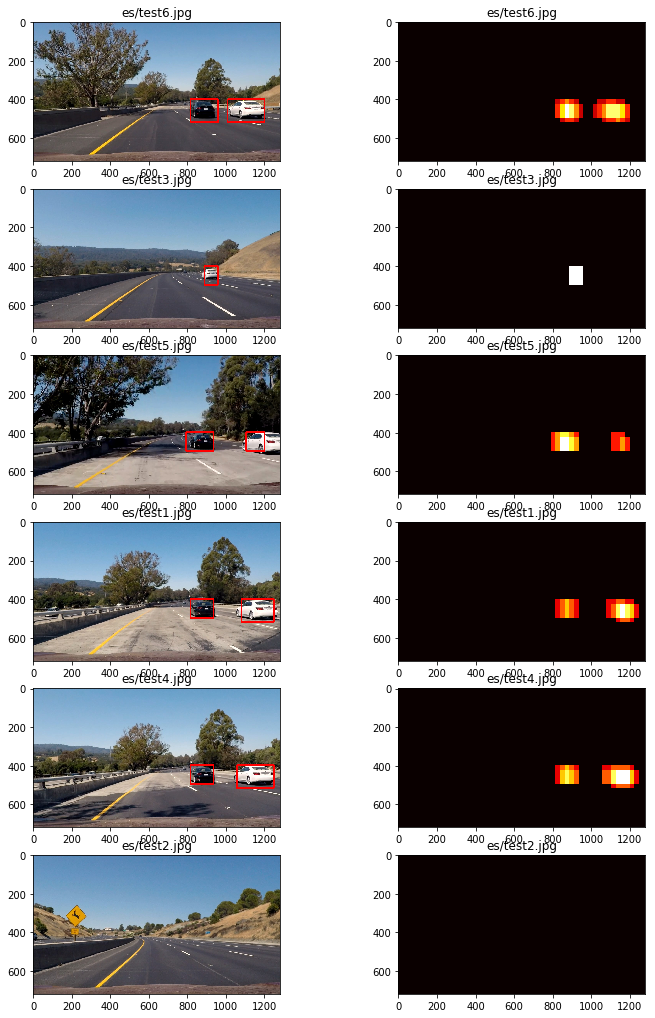

In [11]:
# this code cell outputs the heat maps and detections based on the optimized search algorithm

out_images = []
out_maps = []
scales = [1.0,1.5,2.0]
for img_src in example_images:
    img = mpimg.imread(img_src)

    out_img, heat_map = find_cars(img,scale=scales[1],y_start_stop=[400,656],decision_thresh=0.1)

# multiple scales were tested    
#     out_img2, heat_map2 = find_cars(img,scale=scales[0],y_start_stop=[400,500])
#     out_img3, heat_map3 = find_cars(img,scale=scales[2],y_start_stop=[500,656])
#     heat_map = heat_map + heat_map2 + heat_map3
    
    heat_map = apply_threshold(heat_map,2)
    labels = label(heat_map)
    draw_img = draw_labeled_boxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

## Video Implementation

**1. Video link**

The [video file](./test.mp4) has been generated in the following code cells. It shows the bounding boxes (measurements) and the predicted road positions using the Kalman filter.


**2. Filter for false positives**

A video provides much more information than an image - it stores the constraints of motion in addition to the color and shape information when used for vehicle detection. I decided to exploit these constraints when implementing the pipeline for the `project video` in order to detect as well as track vehicles even when they are occluded. In addition I used the bird's eye view to estimate the road position of every vehicle. Notice that each vehicle belonging to a particular vehicle type, for instance a car, occupies a similar square shape in the bird eye view no matter where they are located on the road in the original image (ignoring the distortion in the warped image due the vehicle's height). In addition motion in the bird's eye view is close to linear. These properties can be used to represent vehicles by a point and track their road positions more efficiently using a Kalman filter. Here's a [link](./warped.mp4) to how bounding boxes look in bird's eye view. This depicts the necessity to find centroids of bounding boxes before projecting.

The thresholded heat maps are integrated over a certain number of time steps. Then they are averaged and thresholded again in order to remove false positives. Regions are labeled as before and boudning boxes are filtered based on size before finding their centroids. These centroids are projected into the bird's eye view and are tracked. Further, for the purpose of tracking, its necessary to know the correspondence between bounding boxes and vehicles. A clustering algorithm similar to K-means clustering was used to assign warped centroids to one of the existing vehicle classes or a new vehicle class.

To further reject false positives, a balance of detections and nondetections was maintained; vehicle classes that had a negative balance were deleted as were those that gave predictions that fell way outside the warped grid. Approximate road positions in the original image were obtained by projecting warped road poisitons back into original image. As a result, finally vehicles were detected and tracked across frames successfully.

In [33]:
class Vehicle():
# class for each vehicle
    
    def __init__(self):
        self.detected = False
        self.n_detections = 0
        self.persist = False
        self.measured_centroid = None
        self.predicted_centroid = None
        self.recent_mcentroids = []
        self.recent_pcentroids = []
        self.kalman = None
        self.delete = False
        self.persistence_level = 0
        
    def kalman_tracking(self):
    # operates kalman filter for warped centroid measurements   
        if self.kalman is None:
        # initializes kalman filter    
            self.kalman = cv2.KalmanFilter(4,2)
            self.kalman.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]],np.float32)
            self.kalman.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]],np.float32)
            self.kalman.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32)*(1e-5)            
            self.kalman.measurementNoiseCov = np.array([[1,0],[0,1]],np.float32)*(1e-1)
            self.kalman.errorCovPost = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32)
            self.kalman.statePost[0,0]  = self.measured_centroid[0]
            self.kalman.statePost[1,0]  = self.measured_centroid[1]
            self.kalman.statePost[2,0]  = 0
            self.kalman.statePost[3,0]  = 0
            self.kalman.statePre[0,0]  = self.measured_centroid[0]
            self.kalman.statePre[1,0]  = self.measured_centroid[1]
            self.kalman.statePre[2,0]  = 0
            self.kalman.statePre[3,0]  = 0
        if self.detected == True:
        # corrects prediction based on measurement     
            predicted = self.kalman.predict()
            self.predicted_centroid = [int(predicted[0]),int(predicted[1])]
            self.kalman.correct(np.array([[self.measured_centroid[0]],[self.measured_centroid[1]]],dtype=np.float32)) 
            self.recent_pcentroids.append(self.predicted_centroid)
        else:
        # predicts in case of no new measurement     
            predicted = self.kalman.predict()
            self.predicted_centroid = [int(predicted[0]),int(predicted[1])] 
            self.recent_pcentroids.append(self.predicted_centroid)
        print(self.predicted_centroid)
        

In [34]:
class Road_Vehicles():
# class for all vehicles on the road    
    def __init__(self):
        self.vehicle_array = []
        self.search_size = 96
        self.detection_thresholds = [-15,15] #15
        self.detection_limits = [-200,240]   #100
        self.persistence_mark = 300
        self.min_persistence = 5
        self.recent_heat_maps = []
        self.average_heat_map = None
        self.prev_frames = 10
        self.track_limits = [0.25,1.25]
    
    def integrate_heat_maps(self,heat_map):
    # integrates heat maps over past frames    
        self.recent_heat_maps.append(heat_map)
        self.recent_heat_maps = self.recent_heat_maps[-self.prev_frames:]
        self.average_heat_map = np.average(self.recent_heat_maps, axis=0).astype(np.float32)
        return self.average_heat_map
    
    def establish_class(self, warped_box_centroids):
    # establishes membership of new centroids to different vehicle and updates detection balance   
        if not(self.vehicle_array):
            for centroid in warped_box_centroids:
                new_vehicle = Vehicle()
                new_vehicle.measured_centroid = centroid
                new_vehicle.recent_mcentroids.append(centroid)
                new_vehicle.n_detections += 1
                new_vehicle.detected = True
                self.vehicle_array.append(new_vehicle)
                
        else:
            for old_vehicle in self.vehicle_array:
                    old_vehicle.detected = False
            
            for centroid in warped_box_centroids:                
                matched = 0
                index = 0
                distances = []
                indices = []
                for old_vehicle in self.vehicle_array:
                    if np.all(np.absolute(np.array(old_vehicle.measured_centroid)-np.array(centroid))<\
                    np.array([1.5*self.search_size,1.5*self.search_size],dtype=np.int32))\
                    and old_vehicle.detected == False:#1
                        norm = np.linalg.norm(np.array(old_vehicle.measured_centroid)-np.array(centroid))
                        distances.append((np.around(norm)))
                        indices.append(index)
                    index += 1
                                                                                            
                if not(distances):
                    new_vehicle = Vehicle()
                    new_vehicle.measured_centroid = centroid
                    new_vehicle.recent_mcentroids.append(centroid)
                    new_vehicle.n_detections += 1
                    new_vehicle.detected = True
                    self.vehicle_array.append(new_vehicle)
                else:
                    number = indices[np.argmin(distances)]                 
                    self.vehicle_array[number].measured_centroid = centroid
                    self.vehicle_array[number].recent_mcentroids.append(centroid)
                    if self.vehicle_array[number].n_detections  < self.detection_limits[1]:
                        self.vehicle_array[number].n_detections += 1      
                    self.vehicle_array[number].detected = True
        
            for vehicle in self.vehicle_array:
                if vehicle.detected == False and vehicle.n_detections  > self.detection_limits[0]:
                    vehicle.n_detections -= 1
        
    def update_positions(self,warped_canvas):
    # updates centroid positions based on kalman filter(s), deletes classes having negative detection balances   
        warp_shape = [warped_canvas.shape[1],warped_canvas.shape[0]]
                      
        for vehicle in self.vehicle_array:
            vehicle.kalman_tracking()
            print(vehicle.n_detections)
            if vehicle.n_detections >= self.persistence_mark:
                vehicle.persistence_level += 1
                if vehicle.persistence_level >= self.min_persistence:
                    vehicle.persist = True
            
            if vehicle.n_detections > self.detection_thresholds[0]\
            and np.all(np.array(vehicle.predicted_centroid) > -self.track_limits[0]*np.array(warp_shape))\
            and np.all(np.array(vehicle.predicted_centroid) < self.track_limits[1]*np.array(warp_shape)):
                if vehicle.n_detections > self.detection_thresholds[1] or vehicle.persist == True:
                    x = vehicle.predicted_centroid[0]
                    y = vehicle.predicted_centroid[1]
                    win_draw = self.search_size
                    cv2.rectangle(warped_canvas, (x-win_draw//2, y-3*win_draw//2),
                             (x+win_draw//2,y+win_draw//2),(255,0,0),thickness=24)
            else: 
                vehicle.delete = True
                
        self.vehicle_array[:] = [vehicle for vehicle in self.vehicle_array if vehicle.delete == False]        
        
        return warped_canvas

In [ ]:
# import pickle

dist_pickle = pickle.load(open('./calibration_pickle.p','rb'))
global mtx, dist
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
win_draw = np.int(window*1.5)

def process_image(img):
# final pipeline  
    
    global mtx, dist
    img = cv2.undistort(img,mtx,dist,None,mtx)
    img_size = (img.shape[1], img.shape[0])
    
    bot_width = 0.60
    mid_width = 0.06
    height_pct = 0.61
    bottom_trim = 0.95
    offset = img.shape[1]*0.45
    shift = 0
    
    src = np.float32([[img.shape[1]*(0.5-mid_width/2)+shift, img.shape[0]*height_pct],
                  [img.shape[1]*(0.5+mid_width/2)+shift, img.shape[0]*height_pct],
                  [img.shape[1]*(0.5+bot_width/2)+shift, img.shape[0]*bottom_trim],
                  [img.shape[1]*(0.5-bot_width/2)+shift, img.shape[0]*bottom_trim]])
 
    dst = np.float32([[offset,0],
                  [img.shape[1]-offset, 0],
                  [img.shape[1]-offset, img.shape[0]],
                  [offset, img.shape[0]]])                                                                      
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    _, heat_map1 = find_cars(img,scale=1.5,y_start_stop=[400,656],decision_thresh=0.1)
    _, heat_map2 = find_cars(img,scale=2.0,y_start_stop=[400,656])
#     _, heat_map3 = find_cars(img,scale=2.5,y_start_stop=[500,656])
    heat_map = heat_map1 + heat_map2
    heat_map = apply_threshold(heat_map,2)    # 2
        
    global vehicles_class
    heat_map = vehicles_class.integrate_heat_maps(heat_map)
    heat_map = apply_threshold(heat_map,0.5)    # 1
    labels = label(heat_map)
    img = draw_labeled_boxes(img, labels)
    box_centroids, warped_box_centroids = find_box_centroids(labels,M)
    
    vehicles_class.establish_class(warped_box_centroids)
    road = np.zeros_like(img)
    road = vehicles_class.update_positions(road)
        
    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_boxes = cv2.addWeighted(img, 1.0, road_warped, 1.0, 0.0)
    
    return road_boxes

In [39]:
# this code cell contains the video output. 
# printed output is (in order): box centroids, warped centroids, predicted centroids, detection balance

global vehicles_class
vehicles_class = Road_Vehicles()

from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_output = 'test.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

HTML("""
<video width="960" height="540" controls>
	<source src="{0}">
</video>
""".format(test_output))

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


 14%|█▍        | 181/1261 [01:16<07:46,  2.31it/s]

[[1199, 482]]
[[1002, 489]]
[0, 0]
1


 14%|█▍        | 182/1261 [01:17<07:41,  2.34it/s]

[[1199, 476]]
[[1035, 460]]
[1431, 698]
2


 15%|█▍        | 183/1261 [01:17<07:42,  2.33it/s]

[[1199, 476]]
[[1035, 460]]
[1282, 554]
3


 15%|█▍        | 184/1261 [01:18<07:38,  2.35it/s]

[[1199, 494]]
[[949, 534]]
[1182, 505]
4


 15%|█▍        | 185/1261 [01:18<07:40,  2.34it/s]

[[1199, 494]]
[[949, 534]]
[1055, 557]
5


 15%|█▍        | 186/1261 [01:19<07:38,  2.34it/s]

[[1199, 494]]
[[949, 534]]
[1002, 571]
6


 15%|█▍        | 187/1261 [01:19<07:43,  2.32it/s]

[[1199, 494]]
[[949, 534]]
[976, 575]
7


 15%|█▍        | 188/1261 [01:19<07:49,  2.28it/s]

[[1187, 494]]
[[942, 534]]
[963, 575]
8


 15%|█▍        | 189/1261 [01:20<07:55,  2.26it/s]

[[1187, 494]]
[[942, 534]]
[951, 573]
9


 15%|█▌        | 190/1261 [01:20<07:54,  2.26it/s]

[[1175, 494]]
[[935, 534]]
[944, 571]
10


 15%|█▌        | 191/1261 [01:21<07:56,  2.24it/s]

[[1175, 494]]
[[935, 534]]
[937, 569]
11


 15%|█▌        | 192/1261 [01:21<08:09,  2.18it/s]

[[1171, 494]]
[[933, 534]]
[932, 567]
12


 15%|█▌        | 193/1261 [01:22<08:17,  2.15it/s]

[[1171, 494]]
[[933, 534]]
[928, 565]
13


 15%|█▌        | 194/1261 [01:22<08:17,  2.14it/s]

[[1171, 494]]
[[933, 534]]
[926, 563]
14


 15%|█▌        | 195/1261 [01:23<08:22,  2.12it/s]

[[1171, 494]]
[[933, 534]]
[924, 562]
15


 16%|█▌        | 196/1261 [01:23<08:24,  2.11it/s]

[[1171, 494]]
[[933, 534]]
[922, 560]
16


 16%|█▌        | 197/1261 [01:24<08:21,  2.12it/s]

[[1171, 494]]
[[933, 534]]
[922, 559]
17


 16%|█▌        | 198/1261 [01:24<08:23,  2.11it/s]

[[1171, 494]]
[[933, 534]]
[921, 557]
18


 16%|█▌        | 199/1261 [01:25<08:23,  2.11it/s]

[[1171, 494]]
[[933, 534]]
[921, 556]
19


 16%|█▌        | 200/1261 [01:25<08:16,  2.14it/s]

[[1171, 494]]
[[933, 534]]
[920, 555]
20


 16%|█▌        | 201/1261 [01:26<08:08,  2.17it/s]

[[1171, 494]]
[[933, 534]]
[920, 554]
21


 16%|█▌        | 202/1261 [01:26<08:00,  2.20it/s]

[[1171, 494]]
[[933, 534]]
[920, 553]
22


 16%|█▌        | 203/1261 [01:26<07:53,  2.23it/s]

[[1171, 494]]
[[933, 534]]
[921, 552]
23


 16%|█▌        | 204/1261 [01:27<07:53,  2.23it/s]

[[1171, 494]]
[[933, 534]]
[921, 551]
24


 16%|█▋        | 205/1261 [01:27<07:56,  2.22it/s]

[[1163, 494]]
[[929, 534]]
[921, 550]
25


 16%|█▋        | 206/1261 [01:28<07:54,  2.22it/s]

[[1163, 494]]
[[929, 534]]
[921, 549]
26


 16%|█▋        | 207/1261 [01:28<07:46,  2.26it/s]

[[1163, 494]]
[[929, 534]]
[920, 548]
27


 16%|█▋        | 208/1261 [01:29<07:43,  2.27it/s]

[[1163, 494]]
[[929, 534]]
[920, 547]
28


 17%|█▋        | 209/1261 [01:29<07:49,  2.24it/s]

[[1163, 494]]
[[929, 534]]
[920, 547]
29


 17%|█▋        | 210/1261 [01:30<07:47,  2.25it/s]

[[1163, 494]]
[[929, 534]]
[920, 546]
30


 17%|█▋        | 211/1261 [01:30<07:42,  2.27it/s]

[[1163, 494]]
[[929, 534]]
[920, 545]
31


 17%|█▋        | 212/1261 [01:30<07:44,  2.26it/s]

[[1163, 488]]
[[951, 513]]
[920, 544]
32


 17%|█▋        | 213/1261 [01:31<07:37,  2.29it/s]

[[1163, 488]]
[[951, 513]]
[924, 540]
33


 17%|█▋        | 214/1261 [01:31<07:36,  2.29it/s]

[[1159, 488]]
[[949, 513]]
[927, 537]
34


 17%|█▋        | 215/1261 [01:32<07:39,  2.27it/s]

[[1159, 494]]
[[926, 534]]
[930, 533]
35


 17%|█▋        | 216/1261 [01:32<07:34,  2.30it/s]

[[1159, 494]]
[[926, 534]]
[929, 534]
36


 17%|█▋        | 217/1261 [01:33<07:34,  2.30it/s]

[[1159, 494]]
[[926, 534]]
[928, 534]
37


 17%|█▋        | 218/1261 [01:33<07:36,  2.29it/s]

[[1159, 494]]
[[926, 534]]
[927, 534]
38


 17%|█▋        | 219/1261 [01:33<07:40,  2.26it/s]

[[1151, 494]]
[[922, 534]]
[926, 534]
39


 17%|█▋        | 220/1261 [01:34<07:40,  2.26it/s]

[[1143, 494]]
[[918, 534]]
[925, 534]
40


 18%|█▊        | 221/1261 [01:34<07:40,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[924, 534]
41


 18%|█▊        | 222/1261 [01:35<07:40,  2.26it/s]

[[1147, 494]]
[[920, 534]]
[922, 534]
42


 18%|█▊        | 223/1261 [01:35<07:37,  2.27it/s]

[[1147, 494]]
[[920, 534]]
[921, 534]
43


 18%|█▊        | 224/1261 [01:36<07:37,  2.27it/s]

[[1147, 494]]
[[920, 534]]
[920, 534]
44


 18%|█▊        | 225/1261 [01:36<07:32,  2.29it/s]

[[1147, 494]]
[[920, 534]]
[919, 534]
45


 18%|█▊        | 226/1261 [01:37<07:31,  2.29it/s]

[[1147, 494]]
[[920, 534]]
[919, 534]
46


 18%|█▊        | 227/1261 [01:37<07:32,  2.28it/s]

[[1147, 494]]
[[920, 534]]
[918, 534]
47


 18%|█▊        | 228/1261 [01:37<07:31,  2.29it/s]

[[1147, 494]]
[[920, 534]]
[918, 534]
48


 18%|█▊        | 229/1261 [01:38<07:27,  2.30it/s]

[[1147, 494]]
[[920, 534]]
[917, 534]
49


 18%|█▊        | 230/1261 [01:38<07:28,  2.30it/s]

[[1151, 494]]
[[922, 534]]
[917, 534]
50


 18%|█▊        | 231/1261 [01:39<07:27,  2.30it/s]

[[1151, 494]]
[[922, 534]]
[917, 534]
51


 18%|█▊        | 232/1261 [01:39<07:29,  2.29it/s]

[[1151, 494]]
[[922, 534]]
[917, 534]
52


 18%|█▊        | 233/1261 [01:40<07:28,  2.29it/s]

[[1151, 494]]
[[922, 534]]
[917, 534]
53


 19%|█▊        | 234/1261 [01:40<07:27,  2.30it/s]

[[1151, 494]]
[[922, 534]]
[917, 534]
54


 19%|█▊        | 235/1261 [01:40<07:24,  2.31it/s]

[[1151, 494]]
[[922, 534]]
[917, 534]
55


 19%|█▊        | 236/1261 [01:41<07:26,  2.30it/s]

[[1151, 494]]
[[922, 534]]
[918, 534]
56


 19%|█▉        | 237/1261 [01:41<07:30,  2.27it/s]

[[1147, 494]]
[[920, 534]]
[918, 534]
57


 19%|█▉        | 238/1261 [01:42<07:33,  2.26it/s]

[[1151, 494]]
[[922, 534]]
[918, 534]
58


 19%|█▉        | 239/1261 [01:42<07:42,  2.21it/s]

[[1139, 494]]
[[915, 534]]
[918, 534]
59


 19%|█▉        | 240/1261 [01:43<07:33,  2.25it/s]

[[1139, 494]]
[[915, 534]]
[917, 534]
60


 19%|█▉        | 241/1261 [01:43<07:30,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[916, 534]
61


 19%|█▉        | 242/1261 [01:44<07:28,  2.27it/s]

[[1139, 494]]
[[915, 534]]
[916, 534]
62


 19%|█▉        | 243/1261 [01:44<07:25,  2.29it/s]

[[1139, 494]]
[[915, 534]]
[915, 534]
63


 19%|█▉        | 244/1261 [01:44<07:22,  2.30it/s]

[[1139, 494]]
[[915, 534]]
[915, 534]
64


 19%|█▉        | 245/1261 [01:45<07:21,  2.30it/s]

[[1139, 494]]
[[915, 534]]
[914, 534]
65


 20%|█▉        | 246/1261 [01:45<07:34,  2.23it/s]

[[1139, 494]]
[[915, 534]]
[914, 534]
66


 20%|█▉        | 247/1261 [01:46<07:42,  2.19it/s]

[[1139, 494]]
[[915, 534]]
[914, 534]
67


 20%|█▉        | 248/1261 [01:46<07:49,  2.16it/s]

[[1151, 494]]
[[922, 534]]
[913, 534]
68


 20%|█▉        | 249/1261 [01:47<07:53,  2.14it/s]

[[1151, 494]]
[[922, 534]]
[914, 534]
69


 20%|█▉        | 250/1261 [01:47<08:09,  2.07it/s]

[[1151, 494]]
[[922, 534]]
[915, 534]
70


 20%|█▉        | 251/1261 [01:48<08:09,  2.06it/s]

[[1151, 494]]
[[922, 534]]
[916, 534]
71


 20%|█▉        | 252/1261 [01:48<08:09,  2.06it/s]

[[1151, 494]]
[[922, 534]]
[916, 534]
72


 20%|██        | 253/1261 [01:49<08:09,  2.06it/s]

[[1151, 494]]
[[922, 534]]
[917, 534]
73


 20%|██        | 254/1261 [01:49<07:57,  2.11it/s]

[[1151, 494]]
[[922, 534]]
[918, 534]
74


 20%|██        | 255/1261 [01:50<07:45,  2.16it/s]

[[1151, 494]]
[[922, 534]]
[918, 534]
75


 20%|██        | 256/1261 [01:50<07:37,  2.20it/s]

[[1151, 494]]
[[922, 534]]
[919, 534]
76


 20%|██        | 257/1261 [01:51<07:32,  2.22it/s]

[[1139, 494]]
[[915, 534]]
[919, 534]
77


 20%|██        | 258/1261 [01:51<07:29,  2.23it/s]

[[1151, 494]]
[[922, 534]]
[918, 534]
78


 21%|██        | 259/1261 [01:51<07:23,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[919, 534]
79


 21%|██        | 260/1261 [01:52<07:22,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[918, 533]
80


 21%|██        | 261/1261 [01:52<07:20,  2.27it/s]

[[1139, 494]]
[[915, 534]]
[918, 533]
81


 21%|██        | 262/1261 [01:53<07:14,  2.30it/s]

[[1139, 494]]
[[915, 534]]
[917, 533]
82


 21%|██        | 263/1261 [01:53<07:15,  2.29it/s]

[[1139, 494]]
[[915, 534]]
[917, 533]
83


 21%|██        | 264/1261 [01:54<07:14,  2.30it/s]

[[1151, 494]]
[[922, 534]]
[917, 533]
84


 21%|██        | 265/1261 [01:54<07:10,  2.31it/s]

[[1151, 494]]
[[922, 534]]
[917, 533]
85


 21%|██        | 266/1261 [01:54<07:12,  2.30it/s]

[[1139, 494]]
[[915, 534]]
[918, 533]
86


 21%|██        | 267/1261 [01:55<07:12,  2.30it/s]

[[1139, 494]]
[[915, 534]]
[917, 533]
87


 21%|██▏       | 268/1261 [01:55<07:15,  2.28it/s]

[[1139, 494]]
[[915, 534]]
[917, 533]
88


 21%|██▏       | 269/1261 [01:56<07:16,  2.27it/s]

[[1139, 494]]
[[915, 534]]
[916, 533]
89


 21%|██▏       | 270/1261 [01:56<07:15,  2.27it/s]

[[1139, 494]]
[[915, 534]]
[916, 533]
90


 21%|██▏       | 271/1261 [01:57<07:13,  2.29it/s]

[[1139, 494]]
[[915, 534]]
[916, 533]
91


 22%|██▏       | 272/1261 [01:57<07:18,  2.25it/s]

[[1139, 494]]
[[915, 534]]
[915, 533]
92


 22%|██▏       | 273/1261 [01:58<07:17,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[915, 533]
93


 22%|██▏       | 274/1261 [01:58<07:17,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[915, 533]
94


 22%|██▏       | 275/1261 [01:58<07:20,  2.24it/s]

[[1139, 494]]
[[915, 534]]
[915, 533]
95


 22%|██▏       | 276/1261 [01:59<07:19,  2.24it/s]

[[1139, 494]]
[[915, 534]]
[915, 533]
96


 22%|██▏       | 277/1261 [01:59<07:20,  2.23it/s]

[[1139, 494]]
[[915, 534]]
[914, 533]
97


 22%|██▏       | 278/1261 [02:00<07:20,  2.23it/s]

[[1139, 494]]
[[915, 534]]
[914, 533]
98


 22%|██▏       | 279/1261 [02:00<07:18,  2.24it/s]

[[1139, 494]]
[[915, 534]]
[914, 533]
99


 22%|██▏       | 280/1261 [02:01<07:17,  2.24it/s]

[[1139, 494]]
[[915, 534]]
[914, 533]
100


 22%|██▏       | 281/1261 [02:01<07:14,  2.25it/s]

[[1151, 494]]
[[922, 534]]
[914, 533]
101


 22%|██▏       | 282/1261 [02:02<07:12,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[915, 533]
102


 22%|██▏       | 283/1261 [02:02<07:12,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[915, 533]
103


 23%|██▎       | 284/1261 [02:02<07:07,  2.28it/s]

[[1139, 494]]
[[915, 534]]
[915, 533]
104


 23%|██▎       | 285/1261 [02:03<07:08,  2.28it/s]

[[1139, 494]]
[[915, 534]]
[915, 533]
105


 23%|██▎       | 286/1261 [02:03<07:12,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[914, 533]
106


 23%|██▎       | 287/1261 [02:04<07:11,  2.26it/s]

[[1139, 494]]
[[915, 534]]
[914, 533]
107


 23%|██▎       | 288/1261 [02:04<07:07,  2.28it/s]

[[1139, 494]]
[[915, 534]]
[914, 533]
108


 23%|██▎       | 289/1261 [02:05<07:08,  2.27it/s]

[[1139, 494]]
[[915, 534]]
[914, 533]
109


 23%|██▎       | 290/1261 [02:05<07:05,  2.28it/s]

[[1139, 494]]
[[915, 534]]
[914, 533]
110


 23%|██▎       | 291/1261 [02:06<07:07,  2.27it/s]

[[1139, 506]]
[[880, 568]]
[914, 533]
111


 23%|██▎       | 292/1261 [02:06<07:03,  2.29it/s]

[[1139, 506]]
[[880, 568]]
[909, 538]
112


 23%|██▎       | 293/1261 [02:06<07:10,  2.25it/s]

[[1139, 506]]
[[880, 568]]
[905, 543]
113


 23%|██▎       | 294/1261 [02:07<07:06,  2.26it/s]

[[1139, 506]]
[[880, 568]]
[900, 547]
114


 23%|██▎       | 295/1261 [02:07<07:05,  2.27it/s]

[[1139, 506]]
[[880, 568]]
[897, 551]
115


 23%|██▎       | 296/1261 [02:08<07:04,  2.27it/s]

[[1135, 506]]
[[878, 568]]
[893, 554]
116


 24%|██▎       | 297/1261 [02:08<07:04,  2.27it/s]

[[1139, 506]]
[[880, 568]]
[890, 557]
117


 24%|██▎       | 298/1261 [02:09<07:04,  2.27it/s]

[[1135, 506]]
[[878, 568]]
[887, 560]
118


 24%|██▎       | 299/1261 [02:09<07:06,  2.25it/s]

[[1135, 506]]
[[878, 568]]
[884, 562]
119


 24%|██▍       | 300/1261 [02:09<07:06,  2.25it/s]

[[1135, 506]]
[[878, 568]]
[881, 565]
120


 24%|██▍       | 301/1261 [02:10<07:15,  2.20it/s]

[[1135, 506]]
[[878, 568]]
[879, 566]
121


 24%|██▍       | 302/1261 [02:10<07:14,  2.21it/s]

[[1135, 506]]
[[878, 568]]
[877, 568]
122


 24%|██▍       | 303/1261 [02:11<07:10,  2.22it/s]

[[1135, 506]]
[[878, 568]]
[876, 570]
123


 24%|██▍       | 304/1261 [02:11<07:08,  2.24it/s]

[[1127, 494]]
[[909, 534]]
[874, 571]
124


 24%|██▍       | 305/1261 [02:12<07:17,  2.19it/s]

[[1127, 494]]
[[909, 534]]
[877, 567]
125


 24%|██▍       | 306/1261 [02:12<07:25,  2.14it/s]

[[1127, 506]]
[[874, 568]]
[880, 564]
126


 24%|██▍       | 307/1261 [02:13<07:30,  2.12it/s]

[[1127, 506]]
[[874, 568]]
[878, 565]
127


 24%|██▍       | 308/1261 [02:13<07:16,  2.18it/s]

[[1127, 506]]
[[874, 568]]
[877, 566]
128


 25%|██▍       | 309/1261 [02:14<07:09,  2.22it/s]

[[1127, 506]]
[[874, 568]]
[875, 567]
129


 25%|██▍       | 310/1261 [02:14<07:08,  2.22it/s]

[[1127, 506]]
[[874, 568]]
[874, 568]
130


 25%|██▍       | 311/1261 [02:15<07:05,  2.23it/s]

[[1127, 506]]
[[874, 568]]
[872, 569]
131


 25%|██▍       | 312/1261 [02:15<07:02,  2.25it/s]

[[1127, 506]]
[[874, 568]]
[871, 570]
132


 25%|██▍       | 313/1261 [02:15<07:00,  2.26it/s]

[[1127, 506]]
[[874, 568]]
[870, 570]
133


 25%|██▍       | 314/1261 [02:16<06:58,  2.26it/s]

[[1127, 506]]
[[874, 568]]
[870, 571]
134


 25%|██▍       | 315/1261 [02:16<06:57,  2.27it/s]

[[1127, 506]]
[[874, 568]]
[869, 571]
135


 25%|██▌       | 316/1261 [02:17<06:56,  2.27it/s]

[[1127, 506]]
[[874, 568]]
[869, 572]
136


 25%|██▌       | 317/1261 [02:17<07:06,  2.21it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
137


 25%|██▌       | 318/1261 [02:18<07:13,  2.17it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
138


 25%|██▌       | 319/1261 [02:18<07:09,  2.19it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
139


 25%|██▌       | 320/1261 [02:19<07:05,  2.21it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
140


 25%|██▌       | 321/1261 [02:19<07:04,  2.22it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
141


 26%|██▌       | 322/1261 [02:19<06:59,  2.24it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
142


 26%|██▌       | 323/1261 [02:20<07:01,  2.22it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
143


 26%|██▌       | 324/1261 [02:20<07:03,  2.21it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
144


 26%|██▌       | 325/1261 [02:21<06:57,  2.24it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
145


 26%|██▌       | 326/1261 [02:21<06:55,  2.25it/s]

[[1127, 506]]
[[874, 568]]
[868, 572]
146


 26%|██▌       | 327/1261 [02:22<06:52,  2.26it/s]

[[1127, 494]]
[[909, 534]]
[868, 571]
147


 26%|██▌       | 328/1261 [02:22<06:46,  2.30it/s]

[[1127, 494]]
[[909, 534]]
[873, 566]
148


 26%|██▌       | 329/1261 [02:23<06:49,  2.27it/s]

[[1127, 494]]
[[909, 534]]
[878, 562]
149


 26%|██▌       | 330/1261 [02:23<06:44,  2.30it/s]

[[1127, 494]]
[[909, 534]]
[883, 557]
150


 26%|██▌       | 331/1261 [02:23<06:53,  2.25it/s]

[[1127, 494]]
[[909, 534]]
[887, 553]
151


 26%|██▋       | 332/1261 [02:24<06:48,  2.27it/s]

[[1127, 494]]
[[909, 534]]
[891, 550]
152


 26%|██▋       | 333/1261 [02:24<06:47,  2.28it/s]

[[1115, 494]]
[[902, 534]]
[894, 547]
153


 26%|██▋       | 334/1261 [02:25<06:42,  2.31it/s]

[[1115, 494]]
[[902, 534]]
[896, 544]
154


 27%|██▋       | 335/1261 [02:25<06:44,  2.29it/s]

[[1115, 494]]
[[902, 534]]
[898, 541]
155


 27%|██▋       | 336/1261 [02:26<06:44,  2.29it/s]

[[1115, 494]]
[[902, 534]]
[900, 539]
156


 27%|██▋       | 337/1261 [02:26<06:44,  2.28it/s]

[[1115, 494]]
[[902, 534]]
[901, 536]
157


 27%|██▋       | 338/1261 [02:26<06:44,  2.28it/s]

[[1115, 494]]
[[902, 534]]
[903, 535]
158


 27%|██▋       | 339/1261 [02:27<06:44,  2.28it/s]

[[1115, 494]]
[[902, 534]]
[904, 533]
159


 27%|██▋       | 340/1261 [02:27<07:19,  2.10it/s]

[[1111, 494]]
[[900, 534]]
[905, 531]
160


 27%|██▋       | 341/1261 [02:28<07:14,  2.12it/s]

[[1111, 494]]
[[900, 534]]
[905, 530]
161


 27%|██▋       | 342/1261 [02:28<07:01,  2.18it/s]

[[1111, 494]]
[[900, 534]]
[905, 529]
162


 27%|██▋       | 343/1261 [02:29<06:54,  2.22it/s]

[[1111, 494]]
[[900, 534]]
[906, 528]
163


 27%|██▋       | 344/1261 [02:29<06:46,  2.26it/s]

[[1111, 494]]
[[900, 534]]
[906, 528]
164


 27%|██▋       | 345/1261 [02:30<06:45,  2.26it/s]

[[1111, 494]]
[[900, 534]]
[906, 527]
165


 27%|██▋       | 346/1261 [02:30<06:42,  2.28it/s]

[[1111, 494]]
[[900, 534]]
[906, 527]
166


 28%|██▊       | 347/1261 [02:31<06:42,  2.27it/s]

[[1111, 494]]
[[900, 534]]
[906, 527]
167


 28%|██▊       | 348/1261 [02:31<06:42,  2.27it/s]

[[1103, 494]]
[[895, 534]]
[906, 526]
168


 28%|██▊       | 349/1261 [02:31<06:42,  2.26it/s]

[[1103, 494]]
[[895, 534]]
[905, 526]
169


 28%|██▊       | 350/1261 [02:32<06:42,  2.26it/s]

[[1103, 494]]
[[895, 534]]
[904, 526]
170


 28%|██▊       | 351/1261 [02:32<06:39,  2.28it/s]

[[1099, 494]]
[[893, 534]]
[903, 526]
171


 28%|██▊       | 352/1261 [02:33<06:38,  2.28it/s]

[[1091, 494]]
[[889, 534]]
[902, 526]
172


 28%|██▊       | 353/1261 [02:33<06:40,  2.27it/s]

[[1091, 494]]
[[889, 534]]
[901, 527]
173


 28%|██▊       | 354/1261 [02:34<06:39,  2.27it/s]

[[1091, 494]]
[[889, 534]]
[899, 527]
174


 28%|██▊       | 355/1261 [02:34<06:53,  2.19it/s]

[[1091, 494]]
[[889, 534]]
[898, 527]
175


 28%|██▊       | 356/1261 [02:35<06:48,  2.22it/s]

[[1091, 494]]
[[889, 534]]
[897, 527]
176


 28%|██▊       | 357/1261 [02:35<06:47,  2.22it/s]

[[1091, 494]]
[[889, 534]]
[895, 528]
177


 28%|██▊       | 358/1261 [02:35<06:43,  2.24it/s]

[[1091, 494]]
[[889, 534]]
[894, 528]
178


 28%|██▊       | 359/1261 [02:36<06:37,  2.27it/s]

[[1091, 494]]
[[889, 534]]
[893, 528]
179


 29%|██▊       | 360/1261 [02:36<06:37,  2.27it/s]

[[1091, 494]]
[[889, 534]]
[892, 529]
180


 29%|██▊       | 361/1261 [02:37<06:46,  2.21it/s]

[[1083, 494]]
[[884, 534]]
[891, 529]
181


 29%|██▊       | 362/1261 [02:37<06:44,  2.22it/s]

[[1083, 494]]
[[884, 534]]
[890, 529]
182


 29%|██▉       | 363/1261 [02:38<06:43,  2.23it/s]

[[1083, 494]]
[[884, 534]]
[889, 530]
183


 29%|██▉       | 364/1261 [02:38<06:37,  2.26it/s]

[[1083, 494]]
[[884, 534]]
[887, 530]
184


 29%|██▉       | 365/1261 [02:39<06:40,  2.24it/s]

[[1083, 494]]
[[884, 534]]
[886, 530]
185


 29%|██▉       | 366/1261 [02:39<06:37,  2.25it/s]

[[1083, 494]]
[[884, 534]]
[885, 530]
186


 29%|██▉       | 367/1261 [02:39<06:38,  2.24it/s]

[[1083, 494]]
[[884, 534]]
[885, 531]
187


 29%|██▉       | 368/1261 [02:40<06:37,  2.25it/s]

[[1079, 494]]
[[882, 534]]
[884, 531]
188


 29%|██▉       | 369/1261 [02:40<06:36,  2.25it/s]

[[1079, 494]]
[[882, 534]]
[883, 531]
189


 29%|██▉       | 370/1261 [02:41<06:33,  2.27it/s]

[[1079, 494]]
[[882, 534]]
[882, 532]
190


 29%|██▉       | 371/1261 [02:41<06:35,  2.25it/s]

[[1079, 494]]
[[882, 534]]
[881, 532]
191


 30%|██▉       | 372/1261 [02:42<06:37,  2.24it/s]

[[1079, 494]]
[[882, 534]]
[881, 532]
192


 30%|██▉       | 373/1261 [02:42<06:33,  2.26it/s]

[[1067, 494]]
[[876, 534]]
[880, 532]
193


 30%|██▉       | 374/1261 [02:43<06:32,  2.26it/s]

[[1067, 494]]
[[876, 534]]
[879, 532]
194


 30%|██▉       | 375/1261 [02:43<06:33,  2.25it/s]

[[1067, 494]]
[[876, 534]]
[878, 533]
195


 30%|██▉       | 376/1261 [02:43<06:27,  2.28it/s]

[[1055, 494]]
[[869, 534]]
[877, 533]
196


 30%|██▉       | 377/1261 [02:44<06:36,  2.23it/s]

[[1055, 494]]
[[869, 534]]
[875, 533]
197


 30%|██▉       | 378/1261 [02:44<06:39,  2.21it/s]

[[1055, 494]]
[[869, 534]]
[873, 533]
198


 30%|███       | 379/1261 [02:45<06:33,  2.24it/s]

[[1055, 494]]
[[869, 534]]
[872, 533]
199


 30%|███       | 380/1261 [02:45<06:34,  2.23it/s]

[[1055, 494]]
[[869, 534]]
[870, 533]
200


 30%|███       | 381/1261 [02:46<06:28,  2.26it/s]

[[1055, 494]]
[[869, 534]]
[869, 533]
201


 30%|███       | 382/1261 [02:46<06:28,  2.26it/s]

[[1055, 494]]
[[869, 534]]
[868, 533]
202


 30%|███       | 383/1261 [02:47<06:27,  2.27it/s]

[[1055, 494]]
[[869, 534]]
[867, 533]
203


 30%|███       | 384/1261 [02:47<06:27,  2.26it/s]

[[1055, 494]]
[[869, 534]]
[866, 534]
204


 31%|███       | 385/1261 [02:47<06:23,  2.29it/s]

[[1055, 494]]
[[869, 534]]
[866, 534]
205


 31%|███       | 386/1261 [02:48<06:22,  2.29it/s]

[[1055, 494]]
[[869, 534]]
[865, 534]
206


 31%|███       | 387/1261 [02:48<06:23,  2.28it/s]

[[1055, 494]]
[[869, 534]]
[865, 534]
207


 31%|███       | 388/1261 [02:49<06:29,  2.24it/s]

[[1043, 494]]
[[862, 534]]
[864, 534]
208


 31%|███       | 389/1261 [02:49<06:36,  2.20it/s]

[[1043, 494]]
[[862, 534]]
[863, 534]
209


 31%|███       | 390/1261 [02:50<06:36,  2.20it/s]

[[1043, 494]]
[[862, 534]]
[862, 534]
210


 31%|███       | 391/1261 [02:50<06:30,  2.23it/s]

[[1031, 494]]
[[856, 534]]
[861, 534]
211


 31%|███       | 392/1261 [02:51<06:33,  2.21it/s]

[[1031, 494]]
[[856, 534]]
[859, 534]
212


 31%|███       | 393/1261 [02:51<06:27,  2.24it/s]

[[1031, 494]]
[[856, 534]]
[858, 534]
213


 31%|███       | 394/1261 [02:51<06:22,  2.26it/s]

[[1031, 494]]
[[856, 534]]
[857, 534]
214


 31%|███▏      | 395/1261 [02:52<06:19,  2.28it/s]

[[1031, 494]]
[[856, 534]]
[855, 534]
215


 31%|███▏      | 396/1261 [02:52<06:19,  2.28it/s]

[[1031, 494]]
[[856, 534]]
[854, 534]
216


 31%|███▏      | 397/1261 [02:53<06:19,  2.28it/s]

[[1031, 494]]
[[856, 534]]
[854, 534]
217


 32%|███▏      | 398/1261 [02:53<06:16,  2.29it/s]

[[1027, 494]]
[[853, 534]]
[853, 534]
218


 32%|███▏      | 399/1261 [02:54<06:23,  2.25it/s]

[[1027, 494]]
[[853, 534]]
[852, 534]
219


 32%|███▏      | 400/1261 [02:54<06:36,  2.17it/s]

[[1027, 494]]
[[853, 534]]
[851, 534]
220


 32%|███▏      | 401/1261 [02:55<06:31,  2.20it/s]

[[1027, 494]]
[[853, 534]]
[850, 534]
221


 32%|███▏      | 402/1261 [02:55<06:25,  2.23it/s]

[[1019, 494]]
[[849, 534]]
[850, 534]
222


 32%|███▏      | 403/1261 [02:55<06:25,  2.22it/s]

[[1019, 494]]
[[849, 534]]
[848, 534]
223


 32%|███▏      | 404/1261 [02:56<06:21,  2.25it/s]

[[1019, 494]]
[[849, 534]]
[848, 534]
224


 32%|███▏      | 405/1261 [02:56<06:15,  2.28it/s]

[[1019, 494]]
[[849, 534]]
[847, 534]
225


 32%|███▏      | 406/1261 [02:57<06:15,  2.28it/s]

[[1019, 494]]
[[849, 534]]
[846, 534]
226


 32%|███▏      | 407/1261 [02:57<06:11,  2.30it/s]

[[1019, 494]]
[[849, 534]]
[845, 534]
227


 32%|███▏      | 408/1261 [02:58<06:11,  2.29it/s]

[[1019, 494]]
[[849, 534]]
[845, 534]
228


 32%|███▏      | 409/1261 [02:58<06:08,  2.31it/s]

[[1019, 494]]
[[849, 534]]
[845, 534]
229


 33%|███▎      | 410/1261 [02:58<06:09,  2.30it/s]

[[1019, 494]]
[[849, 534]]
[844, 534]
230


 33%|███▎      | 411/1261 [02:59<06:08,  2.31it/s]

[[1019, 494]]
[[849, 534]]
[844, 534]
231


 33%|███▎      | 412/1261 [02:59<06:08,  2.31it/s]

[[1019, 494]]
[[849, 534]]
[844, 534]
232


 33%|███▎      | 413/1261 [03:00<06:06,  2.32it/s]

[[1019, 494]]
[[849, 534]]
[844, 534]
233


 33%|███▎      | 414/1261 [03:00<06:05,  2.31it/s]

[[1019, 494]]
[[849, 534]]
[844, 534]
234


 33%|███▎      | 415/1261 [03:01<06:06,  2.31it/s]

[[1007, 494]]
[[842, 534]]
[844, 534]
235


 33%|███▎      | 416/1261 [03:01<06:06,  2.31it/s]

[[1007, 494]]
[[842, 534]]
[843, 534]
236


 33%|███▎      | 417/1261 [03:02<06:05,  2.31it/s]

[[1007, 494]]
[[842, 534]]
[842, 534]
237


 33%|███▎      | 418/1261 [03:02<06:05,  2.30it/s]

[[1007, 494]]
[[842, 534]]
[841, 534]
238


 33%|███▎      | 419/1261 [03:02<06:04,  2.31it/s]

[[1003, 494]]
[[840, 534]]
[841, 534]
239


 33%|███▎      | 420/1261 [03:03<06:04,  2.31it/s]

[[1003, 494]]
[[840, 534]]
[840, 534]
240


 33%|███▎      | 421/1261 [03:03<06:03,  2.31it/s]

[[1003, 494]]
[[840, 534]]
[839, 534]
240


 33%|███▎      | 422/1261 [03:04<06:12,  2.25it/s]

[[1007, 494]]
[[842, 534]]
[839, 534]
240


 34%|███▎      | 423/1261 [03:04<06:09,  2.27it/s]

[[1007, 494]]
[[842, 534]]
[838, 534]
240


 34%|███▎      | 424/1261 [03:05<06:08,  2.27it/s]

[[1007, 488]]
[[858, 513]]
[838, 534]
240


 34%|███▎      | 425/1261 [03:05<06:07,  2.27it/s]

[[1007, 488]]
[[858, 513]]
[840, 531]
240


 34%|███▍      | 426/1261 [03:05<06:05,  2.28it/s]

[[1007, 488]]
[[858, 513]]
[842, 528]
240


 34%|███▍      | 427/1261 [03:06<06:04,  2.29it/s]

[[1019, 488]]
[[866, 513]]
[844, 525]
240


 34%|███▍      | 428/1261 [03:06<06:03,  2.29it/s]

[[1019, 488]]
[[866, 513]]
[847, 523]
240


 34%|███▍      | 429/1261 [03:07<06:02,  2.29it/s]

[[1019, 488]]
[[866, 513]]
[850, 521]
240


 34%|███▍      | 430/1261 [03:07<06:02,  2.30it/s]

[[1019, 488]]
[[866, 513]]
[852, 519]
240


 34%|███▍      | 431/1261 [03:08<06:01,  2.30it/s]

[[1019, 488]]
[[866, 513]]
[855, 517]
240


 34%|███▍      | 432/1261 [03:08<06:02,  2.29it/s]

[[1019, 488]]
[[866, 513]]
[857, 516]
240


 34%|███▍      | 433/1261 [03:09<06:03,  2.28it/s]

[[1007, 488]]
[[858, 513]]
[859, 514]
240


 34%|███▍      | 434/1261 [03:09<06:02,  2.28it/s]

[[1007, 488]]
[[858, 513]]
[859, 513]
240


 34%|███▍      | 435/1261 [03:09<06:01,  2.29it/s]

[[1007, 488]]
[[858, 513]]
[860, 512]
240


 35%|███▍      | 436/1261 [03:10<06:00,  2.29it/s]

[[1003, 494]]
[[840, 534]]
[860, 511]
240


 35%|███▍      | 437/1261 [03:10<05:59,  2.29it/s]

[[1003, 494]]
[[840, 534]]
[858, 513]
240


 35%|███▍      | 438/1261 [03:11<06:00,  2.28it/s]

[[1003, 494]]
[[840, 534]]
[856, 515]
240


 35%|███▍      | 439/1261 [03:11<06:00,  2.28it/s]

[[1003, 494]]
[[840, 534]]
[854, 517]
240


 35%|███▍      | 440/1261 [03:12<06:07,  2.23it/s]

[[995, 494]]
[[836, 534]]
[852, 519]
240


 35%|███▍      | 441/1261 [03:12<06:08,  2.23it/s]

[[995, 494]]
[[836, 534]]
[850, 521]
240


 35%|███▌      | 442/1261 [03:13<06:01,  2.26it/s]

[[1003, 494]]
[[840, 534]]
[847, 523]
240


 35%|███▌      | 443/1261 [03:13<06:01,  2.26it/s]

[[983, 494]]
[[829, 534]]
[846, 524]
240


 35%|███▌      | 444/1261 [03:13<05:55,  2.30it/s]

[[983, 494]]
[[829, 534]]
[843, 526]
240


 35%|███▌      | 445/1261 [03:14<05:57,  2.28it/s]

[[983, 494]]
[[829, 534]]
[841, 527]
240


 35%|███▌      | 446/1261 [03:14<05:52,  2.31it/s]

[[983, 494]]
[[829, 534]]
[838, 528]
240


 35%|███▌      | 447/1261 [03:15<05:53,  2.30it/s]

[[983, 494]]
[[829, 534]]
[836, 529]
240


 36%|███▌      | 448/1261 [03:15<05:49,  2.33it/s]

[[983, 494]]
[[829, 534]]
[834, 530]
240


 36%|███▌      | 449/1261 [03:16<05:51,  2.31it/s]

[[983, 494]]
[[829, 534]]
[833, 531]
240


 36%|███▌      | 450/1261 [03:16<05:48,  2.33it/s]

[[983, 494]]
[[829, 534]]
[831, 532]
240


 36%|███▌      | 451/1261 [03:16<05:52,  2.30it/s]

[[983, 494]]
[[829, 534]]
[830, 533]
240


 36%|███▌      | 452/1261 [03:17<06:00,  2.24it/s]

[[983, 494]]
[[829, 534]]
[828, 533]
240


 36%|███▌      | 453/1261 [03:17<05:53,  2.28it/s]

[[983, 494]]
[[829, 534]]
[827, 534]
240


 36%|███▌      | 454/1261 [03:18<05:54,  2.27it/s]

[[991, 494]]
[[834, 534]]
[827, 534]
240


 36%|███▌      | 455/1261 [03:18<05:55,  2.27it/s]

[[991, 494]]
[[834, 534]]
[827, 535]
240


 36%|███▌      | 456/1261 [03:19<05:51,  2.29it/s]

[[991, 494]]
[[834, 534]]
[827, 535]
240


 36%|███▌      | 457/1261 [03:19<05:53,  2.28it/s]

[[991, 494]]
[[834, 534]]
[827, 535]
240


 36%|███▋      | 458/1261 [03:19<05:52,  2.28it/s]

[[991, 494]]
[[834, 534]]
[827, 535]
240


 36%|███▋      | 459/1261 [03:20<05:53,  2.27it/s]

[[991, 494]]
[[834, 534]]
[827, 536]
240


 36%|███▋      | 460/1261 [03:20<05:48,  2.30it/s]

[[991, 494]]
[[834, 534]]
[827, 536]
240


 37%|███▋      | 461/1261 [03:21<05:50,  2.28it/s]

[[991, 494]]
[[834, 534]]
[827, 536]
240


 37%|███▋      | 462/1261 [03:21<05:46,  2.31it/s]

[[991, 494]]
[[834, 534]]
[828, 536]
240


 37%|███▋      | 463/1261 [03:22<05:54,  2.25it/s]

[[983, 494]]
[[829, 534]]
[828, 536]
240


 37%|███▋      | 464/1261 [03:22<05:54,  2.25it/s]

[[983, 494]]
[[829, 534]]
[828, 536]
240


 37%|███▋      | 465/1261 [03:23<05:53,  2.25it/s]

[[983, 494]]
[[829, 534]]
[827, 536]
240


 37%|███▋      | 466/1261 [03:23<05:52,  2.26it/s]

[[983, 494]]
[[829, 534]]
[827, 536]
240


 37%|███▋      | 467/1261 [03:23<05:58,  2.21it/s]

[[983, 494]]
[[829, 534]]
[827, 536]
240


 37%|███▋      | 468/1261 [03:24<05:54,  2.24it/s]

[[983, 494]]
[[829, 534]]
[827, 536]
240


 37%|███▋      | 469/1261 [03:24<05:52,  2.24it/s]

[[983, 494]]
[[829, 534]]
[826, 536]
240


 37%|███▋      | 470/1261 [03:25<05:52,  2.25it/s]

[[983, 494]]
[[829, 534]]
[826, 536]
240


 37%|███▋      | 471/1261 [03:25<05:55,  2.22it/s]

[[983, 494]]
[[829, 534]]
[826, 535]
240


 37%|███▋      | 472/1261 [03:26<05:56,  2.21it/s]

[[983, 494]]
[[829, 534]]
[826, 535]
240


 38%|███▊      | 473/1261 [03:26<05:55,  2.21it/s]

[[983, 494]]
[[829, 534]]
[826, 535]
240


 38%|███▊      | 474/1261 [03:27<05:50,  2.25it/s]

[[983, 494]]
[[829, 534]]
[826, 535]
240


 38%|███▊      | 475/1261 [03:27<05:51,  2.24it/s]

[[983, 494]]
[[829, 534]]
[826, 535]
240


 38%|███▊      | 476/1261 [03:28<05:51,  2.23it/s]

[[983, 494]]
[[829, 534]]
[826, 535]
240


 38%|███▊      | 477/1261 [03:28<05:46,  2.26it/s]

[[975, 494]]
[[825, 534]]
[826, 535]
240


 38%|███▊      | 478/1261 [03:28<05:48,  2.25it/s]

[[975, 494]]
[[825, 534]]
[826, 535]
240


 38%|███▊      | 479/1261 [03:29<05:47,  2.25it/s]

[[975, 494]]
[[825, 534]]
[825, 535]
240


 38%|███▊      | 480/1261 [03:29<05:52,  2.22it/s]

[[975, 494]]
[[825, 534]]
[825, 535]
240


 38%|███▊      | 481/1261 [03:30<05:45,  2.26it/s]

[[975, 494]]
[[825, 534]]
[825, 534]
240


 38%|███▊      | 482/1261 [03:30<05:47,  2.24it/s]

[[983, 494]]
[[829, 534]]
[824, 534]
240


 38%|███▊      | 483/1261 [03:31<05:46,  2.25it/s]

[[983, 494]]
[[829, 534]]
[825, 534]
240


 38%|███▊      | 484/1261 [03:31<05:45,  2.25it/s]

[[983, 494]]
[[829, 534]]
[825, 534]
240


 38%|███▊      | 485/1261 [03:32<05:42,  2.27it/s]

[[983, 488]]
[[844, 513]]
[825, 534]
240


 39%|███▊      | 486/1261 [03:32<05:46,  2.23it/s]

[[983, 470]]
[[908, 424]]
[828, 531]
240


 39%|███▊      | 487/1261 [03:32<05:44,  2.25it/s]

[[983, 470]]
[[908, 424]]
[839, 516]
240


 39%|███▊      | 488/1261 [03:33<05:51,  2.20it/s]

[[983, 470]]
[[908, 424]]
[849, 501]
240


 39%|███▉      | 489/1261 [03:33<05:46,  2.23it/s]

[[983, 470]]
[[908, 424]]
[859, 488]
240


 39%|███▉      | 490/1261 [03:34<05:46,  2.23it/s]

[[983, 470]]
[[908, 424]]
[868, 476]
240


 39%|███▉      | 491/1261 [03:34<05:40,  2.26it/s]

[[983, 470]]
[[908, 424]]
[876, 465]
240


 39%|███▉      | 492/1261 [03:35<05:43,  2.24it/s]

[[983, 470]]
[[908, 424]]
[883, 456]
240


 39%|███▉      | 493/1261 [03:35<05:46,  2.22it/s]

[[971, 470]]
[[898, 424]]
[890, 447]
240


 39%|███▉      | 494/1261 [03:36<05:49,  2.19it/s]

[[971, 470]]
[[898, 424]]
[894, 439]
240


 39%|███▉      | 495/1261 [03:36<05:51,  2.18it/s]

[[971, 470]]
[[898, 424]]
[898, 432]
240


 39%|███▉      | 496/1261 [03:36<05:48,  2.20it/s]

[[963, 470]]
[[892, 424]]
[901, 426]
240


 39%|███▉      | 497/1261 [03:37<05:45,  2.21it/s]

[[963, 470]]
[[892, 424]]
[903, 421]
240


 39%|███▉      | 498/1261 [03:37<05:44,  2.21it/s]

[[963, 470]]
[[892, 424]]
[905, 416]
240


 40%|███▉      | 499/1261 [03:38<05:50,  2.18it/s]

[[963, 470]]
[[892, 424]]
[906, 412]
240


 40%|███▉      | 500/1261 [03:38<05:42,  2.22it/s]

[[959, 470]]
[[889, 424]]
[907, 409]
240


 40%|███▉      | 501/1261 [03:39<05:42,  2.22it/s]

[[959, 470]]
[[889, 424]]
[907, 406]
240


 40%|███▉      | 502/1261 [03:39<05:36,  2.26it/s]

[[963, 470]]
[[892, 424]]
[907, 404]
240


 40%|███▉      | 503/1261 [03:40<05:39,  2.23it/s]

[[963, 470]]
[[892, 424]]
[908, 402]
240


 40%|███▉      | 504/1261 [03:40<05:34,  2.26it/s]

[[963, 470]]
[[892, 424]]
[908, 401]
240


 40%|████      | 505/1261 [03:41<05:36,  2.25it/s]

[[959, 470]]
[[889, 424]]
[908, 400]
240


 40%|████      | 506/1261 [03:41<05:36,  2.25it/s]

[[959, 470]]
[[889, 424]]
[907, 399]
240


 40%|████      | 507/1261 [03:41<05:31,  2.27it/s]

[[959, 470]]
[[889, 424]]
[906, 399]
240


 40%|████      | 508/1261 [03:42<05:31,  2.27it/s]

[[959, 470]]
[[889, 424]]
[906, 399]
240


 40%|████      | 509/1261 [03:42<05:33,  2.26it/s]

[[959, 470]]
[[889, 424]]
[905, 399]
240


 40%|████      | 510/1261 [03:43<05:28,  2.29it/s]

[[959, 470]]
[[889, 424]]
[904, 400]
240


 41%|████      | 511/1261 [03:43<05:30,  2.27it/s]

[[951, 470]]
[[883, 424]]
[903, 400]
240


 41%|████      | 512/1261 [03:44<05:31,  2.26it/s]

[[959, 470]]
[[889, 424]]
[901, 401]
240


 41%|████      | 513/1261 [03:44<05:26,  2.29it/s]

[[959, 470]]
[[889, 424]]
[900, 402]
240


 41%|████      | 514/1261 [03:44<05:22,  2.31it/s]

[[959, 470]]
[[889, 424]]
[900, 403]
240


 41%|████      | 515/1261 [03:45<05:25,  2.29it/s]

[[959, 470]]
[[889, 424]]
[899, 404]
240


 41%|████      | 516/1261 [03:45<05:21,  2.32it/s]

[[959, 470]]
[[889, 424]]
[898, 405]
240


 41%|████      | 517/1261 [03:46<05:31,  2.24it/s]

[[959, 470]]
[[889, 424]]
[897, 406]
240


 41%|████      | 518/1261 [03:46<05:33,  2.23it/s]

[[959, 470]]
[[889, 424]]
[896, 407]
240


 41%|████      | 519/1261 [03:47<05:27,  2.26it/s]

[[959, 470]]
[[889, 424]]
[896, 408]
240


 41%|████      | 520/1261 [03:47<05:25,  2.28it/s]

[[959, 470]]
[[889, 424]]
[895, 409]
240


 41%|████▏     | 521/1261 [03:48<05:39,  2.18it/s]

[[967, 470]]
[[895, 424]]
[894, 410]
240


 41%|████▏     | 522/1261 [03:48<05:32,  2.22it/s]

[[959, 470]]
[[889, 424]]
[894, 411]
240


 41%|████▏     | 523/1261 [03:48<05:28,  2.25it/s]

[[959, 470]]
[[889, 424]]
[894, 412]
240


 42%|████▏     | 524/1261 [03:49<05:31,  2.22it/s]

[[959, 470]]
[[889, 424]]
[893, 413]
240


 42%|████▏     | 525/1261 [03:49<05:33,  2.21it/s]

[[959, 470]]
[[889, 424]]
[892, 414]
240


 42%|████▏     | 526/1261 [03:50<05:36,  2.18it/s]

[[959, 470]]
[[889, 424]]
[892, 415]
240


 42%|████▏     | 527/1261 [03:50<05:34,  2.19it/s]

[[967, 470]]
[[895, 424]]
[891, 416]
240


 42%|████▏     | 528/1261 [03:51<05:28,  2.23it/s]

[[967, 470]]
[[895, 424]]
[892, 417]
240


 42%|████▏     | 529/1261 [03:51<05:22,  2.27it/s]

[[967, 470]]
[[895, 424]]
[892, 418]
240


 42%|████▏     | 530/1261 [03:52<05:23,  2.26it/s]

[[967, 470]]
[[895, 424]]
[892, 419]
240


 42%|████▏     | 531/1261 [03:52<05:19,  2.28it/s]

[[967, 470]]
[[895, 424]]
[893, 419]
240


 42%|████▏     | 532/1261 [03:52<05:22,  2.26it/s]

[[967, 470]]
[[895, 424]]
[893, 420]
240


 42%|████▏     | 533/1261 [03:53<05:23,  2.25it/s]

[[967, 470]]
[[895, 424]]
[893, 420]
240


 42%|████▏     | 534/1261 [03:53<05:23,  2.25it/s]

[[967, 470]]
[[895, 424]]
[[967, 470], [419, 482]]
[[895, 424], [496, 489]]
[894, 421]
240
[0, 0]
1


 42%|████▏     | 535/1261 [03:54<05:18,  2.28it/s]

[[967, 470]]
[[895, 424]]
[[967, 470], [407, 482]]
[[895, 424], [489, 489]]
[894, 421]
240
[708, 698]
2


 43%|████▎     | 536/1261 [03:54<05:20,  2.26it/s]

[[967, 470]]
[[895, 424]]
[[967, 470], [407, 496]]
[[895, 424], [514, 540]]
[894, 422]
240
[598, 600]
3


 43%|████▎     | 537/1261 [03:55<05:19,  2.26it/s]

[[967, 470]]
[[895, 424]]
[[967, 470], [407, 496]]
[[895, 424], [514, 540]]
[894, 422]
240
[578, 613]
4


 43%|████▎     | 538/1261 [03:55<05:22,  2.24it/s]

[[967, 470]]
[[895, 424]]
[[967, 470], [399, 496]]
[[895, 424], [509, 540]]
[894, 423]
240
[563, 603]
5


 43%|████▎     | 539/1261 [03:56<05:18,  2.27it/s]

[[967, 470]]
[[895, 424]]
[[967, 470], [395, 500]]
[[895, 424], [513, 552]]
[894, 423]
240
[550, 594]
6


 43%|████▎     | 540/1261 [03:56<05:18,  2.27it/s]

[[959, 470]]
[[889, 424]]
[895, 423]
240
[544, 594]
5


 43%|████▎     | 541/1261 [03:56<05:15,  2.28it/s]

[[967, 470]]
[[895, 424]]
[894, 424]
240
[557, 616]
4


 43%|████▎     | 542/1261 [03:57<05:17,  2.26it/s]

[[959, 470]]
[[889, 424]]
[894, 424]
240
[570, 638]
3


 43%|████▎     | 543/1261 [03:57<05:13,  2.29it/s]

[[959, 470]]
[[889, 424]]
[893, 424]
240
[583, 660]
2


 43%|████▎     | 544/1261 [03:58<05:19,  2.24it/s]

[[959, 470]]
[[889, 424]]
[893, 424]
240
[596, 683]
1


 43%|████▎     | 545/1261 [03:58<05:15,  2.27it/s]

[[959, 470]]
[[889, 424]]
[892, 424]
240
[609, 705]
0


 43%|████▎     | 546/1261 [03:59<05:16,  2.26it/s]

[[959, 470]]
[[889, 424]]
[891, 424]
240
[622, 727]
-1


 43%|████▎     | 547/1261 [03:59<05:12,  2.28it/s]

[[959, 470]]
[[889, 424]]
[891, 424]
240
[635, 749]
-2


 43%|████▎     | 548/1261 [04:00<05:14,  2.27it/s]

[[959, 470]]
[[889, 424]]
[890, 424]
240
[649, 771]
-3


 44%|████▎     | 549/1261 [04:00<05:16,  2.25it/s]

[[959, 470]]
[[889, 424]]
[890, 424]
240
[662, 793]
-4


 44%|████▎     | 550/1261 [04:00<05:22,  2.20it/s]

[[959, 470]]
[[889, 424]]
[890, 425]
240
[675, 815]
-5


 44%|████▎     | 551/1261 [04:01<05:17,  2.24it/s]

[[959, 470]]
[[889, 424]]
[889, 425]
240
[688, 837]
-6


 44%|████▍     | 552/1261 [04:01<05:17,  2.23it/s]

[[959, 470]]
[[889, 424]]
[889, 425]
240
[701, 859]
-7


 44%|████▍     | 553/1261 [04:02<05:14,  2.25it/s]

[[959, 470]]
[[889, 424]]
[889, 425]
240
[714, 881]
-8


 44%|████▍     | 554/1261 [04:02<05:16,  2.23it/s]

[[959, 470]]
[[889, 424]]
[888, 425]
240
[727, 903]
-9


 44%|████▍     | 555/1261 [04:03<05:13,  2.25it/s]

[[959, 470]]
[[889, 424]]
[888, 425]
240


 44%|████▍     | 556/1261 [04:03<05:15,  2.24it/s]

[[959, 470]]
[[889, 424]]
[888, 424]
240


 44%|████▍     | 557/1261 [04:04<05:10,  2.27it/s]

[[959, 470]]
[[889, 424]]
[888, 424]
240


 44%|████▍     | 558/1261 [04:04<05:09,  2.27it/s]

[[959, 470]]
[[889, 424]]
[888, 424]
240


 44%|████▍     | 559/1261 [04:04<05:10,  2.26it/s]

[[959, 470]]
[[889, 424]]
[888, 424]
240


 44%|████▍     | 560/1261 [04:05<05:11,  2.25it/s]

[[959, 470]]
[[889, 424]]
[888, 424]
240


 44%|████▍     | 561/1261 [04:05<05:12,  2.24it/s]

[[959, 470]]
[[889, 424]]
[888, 424]
240


 45%|████▍     | 562/1261 [04:06<05:11,  2.24it/s]

[[959, 470]]
[[889, 424]]
[888, 424]
240


 45%|████▍     | 563/1261 [04:06<05:12,  2.23it/s]

[[959, 470]]
[[889, 424]]
[887, 424]
240


 45%|████▍     | 564/1261 [04:07<05:13,  2.22it/s]

[[959, 470]]
[[889, 424]]
[887, 424]
240


 45%|████▍     | 565/1261 [04:07<05:12,  2.23it/s]

[887, 424]
239


 45%|████▍     | 566/1261 [04:08<05:12,  2.22it/s]

[887, 424]
238


 45%|████▍     | 567/1261 [04:08<05:12,  2.22it/s]

[887, 424]
237


 45%|████▌     | 568/1261 [04:09<05:12,  2.22it/s]

[887, 424]
236


 45%|████▌     | 569/1261 [04:09<05:09,  2.23it/s]

[887, 424]
235


 45%|████▌     | 570/1261 [04:09<05:09,  2.23it/s]

[887, 424]
234


 45%|████▌     | 571/1261 [04:10<05:06,  2.25it/s]

[[947, 470]]
[[879, 424]]
[887, 424]
235


 45%|████▌     | 572/1261 [04:10<05:06,  2.25it/s]

[[947, 470]]
[[879, 424]]
[884, 424]
236


 45%|████▌     | 573/1261 [04:11<05:03,  2.27it/s]

[[947, 470]]
[[879, 424]]
[883, 424]
237


 46%|████▌     | 574/1261 [04:11<05:08,  2.23it/s]

[[947, 470]]
[[879, 424]]
[881, 424]
238


 46%|████▌     | 575/1261 [04:12<05:03,  2.26it/s]

[[947, 470]]
[[879, 424]]
[880, 424]
239


 46%|████▌     | 576/1261 [04:12<05:04,  2.25it/s]

[[947, 470]]
[[879, 424]]
[880, 424]
240


 46%|████▌     | 577/1261 [04:12<05:01,  2.27it/s]

[[947, 470]]
[[879, 424]]
[879, 424]
240


 46%|████▌     | 578/1261 [04:13<05:04,  2.25it/s]

[[947, 470]]
[[879, 424]]
[878, 424]
240


 46%|████▌     | 579/1261 [04:13<05:06,  2.23it/s]

[[947, 470]]
[[879, 424]]
[878, 424]
240


 46%|████▌     | 580/1261 [04:14<05:06,  2.23it/s]

[[947, 470]]
[[879, 424]]
[878, 424]
240


 46%|████▌     | 581/1261 [04:14<05:02,  2.25it/s]

[[947, 470]]
[[879, 424]]
[877, 424]
240


 46%|████▌     | 582/1261 [04:15<05:03,  2.24it/s]

[[947, 470]]
[[879, 424]]
[877, 424]
240


 46%|████▌     | 583/1261 [04:15<04:58,  2.27it/s]

[[947, 470]]
[[879, 424]]
[877, 424]
240


 46%|████▋     | 584/1261 [04:16<05:01,  2.24it/s]

[[947, 470]]
[[879, 424]]
[877, 424]
240


 46%|████▋     | 585/1261 [04:16<05:03,  2.23it/s]

[[947, 470]]
[[879, 424]]
[876, 424]
240


 46%|████▋     | 586/1261 [04:17<05:02,  2.23it/s]

[[947, 470]]
[[879, 424]]
[876, 424]
240


 47%|████▋     | 587/1261 [04:17<05:01,  2.24it/s]

[[947, 470]]
[[879, 424]]
[876, 423]
240


 47%|████▋     | 588/1261 [04:17<05:01,  2.23it/s]

[[947, 470]]
[[879, 424]]
[876, 423]
240


 47%|████▋     | 589/1261 [04:18<04:56,  2.26it/s]

[[947, 470]]
[[879, 424]]
[876, 423]
240


 47%|████▋     | 590/1261 [04:18<04:58,  2.25it/s]

[[947, 470]]
[[879, 424]]
[876, 423]
240


 47%|████▋     | 591/1261 [04:19<04:58,  2.25it/s]

[[947, 470]]
[[879, 424]]
[876, 423]
240


 47%|████▋     | 592/1261 [04:19<05:01,  2.22it/s]

[[947, 470]]
[[879, 424]]
[876, 423]
240


 47%|████▋     | 593/1261 [04:20<05:05,  2.19it/s]

[[947, 470]]
[[879, 424]]
[876, 423]
240


 47%|████▋     | 594/1261 [04:20<05:05,  2.18it/s]

[[947, 470]]
[[879, 424]]
[876, 423]
240


 47%|████▋     | 595/1261 [04:21<05:03,  2.19it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 47%|████▋     | 596/1261 [04:21<05:02,  2.20it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 47%|████▋     | 597/1261 [04:22<05:06,  2.17it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 47%|████▋     | 598/1261 [04:22<05:04,  2.18it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 48%|████▊     | 599/1261 [04:22<04:56,  2.23it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 48%|████▊     | 600/1261 [04:23<04:56,  2.23it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 48%|████▊     | 601/1261 [04:23<04:50,  2.27it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 48%|████▊     | 602/1261 [04:24<04:52,  2.26it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 48%|████▊     | 603/1261 [04:24<04:48,  2.28it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 48%|████▊     | 604/1261 [04:25<04:50,  2.26it/s]

[[947, 470]]
[[879, 424]]
[877, 423]
240


 48%|████▊     | 605/1261 [04:25<04:47,  2.29it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 48%|████▊     | 606/1261 [04:25<04:48,  2.27it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 48%|████▊     | 607/1261 [04:26<04:54,  2.22it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 48%|████▊     | 608/1261 [04:26<04:53,  2.23it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 48%|████▊     | 609/1261 [04:27<04:53,  2.22it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 48%|████▊     | 610/1261 [04:27<04:53,  2.22it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 48%|████▊     | 611/1261 [04:28<04:59,  2.17it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▊     | 612/1261 [04:28<04:57,  2.18it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▊     | 613/1261 [04:29<04:54,  2.20it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▊     | 614/1261 [04:29<04:52,  2.21it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▉     | 615/1261 [04:30<04:52,  2.21it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▉     | 616/1261 [04:30<04:51,  2.22it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▉     | 617/1261 [04:30<04:49,  2.23it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▉     | 618/1261 [04:31<04:47,  2.24it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▉     | 619/1261 [04:31<04:45,  2.25it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▉     | 620/1261 [04:32<04:45,  2.24it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▉     | 621/1261 [04:32<04:45,  2.24it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▉     | 622/1261 [04:33<04:44,  2.24it/s]

[[947, 470]]
[[879, 424]]
[878, 423]
240


 49%|████▉     | 623/1261 [04:33<04:43,  2.25it/s]

[[947, 470]]
[[879, 424]]
[879, 423]
240


 49%|████▉     | 624/1261 [04:34<04:42,  2.26it/s]

[[947, 470]]
[[879, 424]]
[879, 423]
240


 50%|████▉     | 625/1261 [04:34<04:42,  2.25it/s]

[[947, 470]]
[[879, 424]]
[879, 423]
240


 50%|████▉     | 626/1261 [04:34<04:43,  2.24it/s]

[[947, 470]]
[[879, 424]]
[879, 423]
240


 50%|████▉     | 627/1261 [04:35<04:48,  2.20it/s]

[[947, 470]]
[[879, 424]]
[879, 423]
240


 50%|████▉     | 628/1261 [04:35<04:46,  2.21it/s]

[[947, 470]]
[[879, 424]]
[879, 423]
240


 50%|████▉     | 629/1261 [04:36<04:40,  2.25it/s]

[[947, 470]]
[[879, 424]]
[879, 423]
240


 50%|████▉     | 630/1261 [04:36<04:40,  2.25it/s]

[[947, 470]]
[[879, 424]]
[879, 423]
240


 50%|█████     | 631/1261 [04:37<04:39,  2.25it/s]

[[947, 470]]
[[879, 424]]
[879, 423]
240


 50%|█████     | 632/1261 [04:37<04:39,  2.25it/s]

[[947, 470]]
[[879, 424]]
[879, 424]
240


 50%|█████     | 633/1261 [04:38<04:40,  2.24it/s]

[879, 424]
239


 50%|█████     | 634/1261 [04:38<04:41,  2.23it/s]

[879, 424]
238


 50%|█████     | 635/1261 [04:38<04:40,  2.23it/s]

[879, 424]
237


 50%|█████     | 636/1261 [04:39<04:43,  2.21it/s]

[879, 424]
236


 51%|█████     | 637/1261 [04:39<04:40,  2.22it/s]

[879, 424]
235


 51%|█████     | 638/1261 [04:40<04:44,  2.19it/s]

[879, 424]
234


 51%|█████     | 639/1261 [04:40<04:41,  2.21it/s]

[879, 424]
233


 51%|█████     | 640/1261 [04:41<04:39,  2.22it/s]

[879, 424]
232


 51%|█████     | 641/1261 [04:41<04:38,  2.23it/s]

[879, 424]
231


 51%|█████     | 642/1261 [04:42<04:36,  2.24it/s]

[879, 424]
230


 51%|█████     | 643/1261 [04:42<04:34,  2.25it/s]

[879, 424]
229


 51%|█████     | 644/1261 [04:43<04:29,  2.29it/s]

[879, 424]
228


 51%|█████     | 645/1261 [04:43<04:30,  2.28it/s]

[879, 424]
227


 51%|█████     | 646/1261 [04:43<04:31,  2.27it/s]

[879, 424]
226


 51%|█████▏    | 647/1261 [04:44<04:29,  2.28it/s]

[879, 424]
225


 51%|█████▏    | 648/1261 [04:44<04:29,  2.27it/s]

[[923, 470]]
[[861, 424]]
[879, 424]
226


 51%|█████▏    | 649/1261 [04:45<04:29,  2.27it/s]

[[923, 470]]
[[861, 424]]
[870, 424]
227


 52%|█████▏    | 650/1261 [04:45<04:30,  2.26it/s]

[[923, 470]]
[[861, 424]]
[866, 424]
228


 52%|█████▏    | 651/1261 [04:46<04:29,  2.26it/s]

[[923, 470]]
[[861, 424]]
[864, 424]
229


 52%|█████▏    | 652/1261 [04:46<04:28,  2.27it/s]

[[923, 470]]
[[861, 424]]
[862, 424]
230


 52%|█████▏    | 653/1261 [04:46<04:28,  2.27it/s]

[[923, 470]]
[[861, 424]]
[861, 424]
231


 52%|█████▏    | 654/1261 [04:47<04:27,  2.27it/s]

[[923, 470]]
[[861, 424]]
[860, 424]
232


 52%|█████▏    | 655/1261 [04:47<04:27,  2.26it/s]

[[923, 470]]
[[861, 424]]
[860, 424]
233


 52%|█████▏    | 656/1261 [04:48<04:28,  2.25it/s]

[[923, 470]]
[[861, 424]]
[859, 424]
234


 52%|█████▏    | 657/1261 [04:48<04:28,  2.25it/s]

[[923, 470]]
[[861, 424]]
[859, 424]
235


 52%|█████▏    | 658/1261 [04:49<04:28,  2.25it/s]

[[923, 470]]
[[861, 424]]
[858, 424]
236


 52%|█████▏    | 659/1261 [04:49<04:27,  2.25it/s]

[[923, 470]]
[[861, 424]]
[858, 424]
237


 52%|█████▏    | 660/1261 [04:50<04:26,  2.25it/s]

[[923, 470]]
[[861, 424]]
[858, 424]
238


 52%|█████▏    | 661/1261 [04:50<04:26,  2.25it/s]

[[923, 470]]
[[861, 424]]
[858, 424]
239


 52%|█████▏    | 662/1261 [04:50<04:22,  2.28it/s]

[[923, 470]]
[[861, 424]]
[857, 424]
240


 53%|█████▎    | 663/1261 [04:51<04:22,  2.28it/s]

[857, 424]
239


 53%|█████▎    | 664/1261 [04:51<04:22,  2.28it/s]

[857, 424]
238


 53%|█████▎    | 665/1261 [04:52<04:28,  2.22it/s]

[856, 424]
237


 53%|█████▎    | 666/1261 [04:52<04:27,  2.23it/s]

[856, 424]
236


 53%|█████▎    | 667/1261 [04:53<04:24,  2.25it/s]

[855, 424]
235


 53%|█████▎    | 668/1261 [04:53<04:23,  2.25it/s]

[855, 424]
234


 53%|█████▎    | 669/1261 [04:54<04:26,  2.22it/s]

[854, 424]
233


 53%|█████▎    | 670/1261 [04:54<04:23,  2.24it/s]

[853, 424]
232


 53%|█████▎    | 671/1261 [04:54<04:22,  2.24it/s]

[853, 424]
231


 53%|█████▎    | 672/1261 [04:55<04:21,  2.26it/s]

[852, 424]
230


 53%|█████▎    | 673/1261 [04:55<04:20,  2.26it/s]

[852, 424]
229


 53%|█████▎    | 674/1261 [04:56<04:19,  2.26it/s]

[851, 424]
228


 54%|█████▎    | 675/1261 [04:56<04:15,  2.29it/s]

[[923, 470]]
[[861, 424]]
[851, 424]
229


 54%|█████▎    | 676/1261 [04:57<04:16,  2.28it/s]

[[923, 470]]
[[861, 424]]
[854, 424]
230


 54%|█████▎    | 677/1261 [04:57<04:17,  2.27it/s]

[[923, 470]]
[[861, 424]]
[856, 424]
231


 54%|█████▍    | 678/1261 [04:58<04:17,  2.26it/s]

[[923, 470]]
[[861, 424]]
[857, 424]
232


 54%|█████▍    | 679/1261 [04:58<04:14,  2.29it/s]

[[923, 470]]
[[861, 424]]
[858, 424]
233


 54%|█████▍    | 680/1261 [04:58<04:15,  2.28it/s]

[858, 424]
232


 54%|█████▍    | 681/1261 [04:59<04:11,  2.31it/s]

[858, 424]
231


 54%|█████▍    | 682/1261 [04:59<04:12,  2.30it/s]

[858, 424]
230


 54%|█████▍    | 683/1261 [05:00<04:08,  2.32it/s]

[858, 424]
229


 54%|█████▍    | 684/1261 [05:00<04:11,  2.30it/s]

[858, 424]
228


 54%|█████▍    | 685/1261 [05:01<04:08,  2.32it/s]

[858, 424]
227


 54%|█████▍    | 686/1261 [05:01<04:09,  2.30it/s]

[858, 424]
226


 54%|█████▍    | 687/1261 [05:01<04:06,  2.33it/s]

[857, 424]
225


 55%|█████▍    | 688/1261 [05:02<04:07,  2.31it/s]

[857, 424]
224


 55%|█████▍    | 689/1261 [05:02<04:05,  2.33it/s]

[857, 424]
223


 55%|█████▍    | 690/1261 [05:03<04:05,  2.32it/s]

[857, 424]
222


 55%|█████▍    | 691/1261 [05:03<04:07,  2.30it/s]

[857, 424]
221


 55%|█████▍    | 692/1261 [05:04<04:08,  2.29it/s]

[857, 424]
220


 55%|█████▍    | 693/1261 [05:04<04:10,  2.27it/s]

[857, 424]
219


 55%|█████▌    | 694/1261 [05:05<04:12,  2.24it/s]

[857, 424]
218


 55%|█████▌    | 695/1261 [05:05<04:08,  2.28it/s]

[857, 424]
217


 55%|█████▌    | 696/1261 [05:05<04:08,  2.27it/s]

[857, 424]
216


 55%|█████▌    | 697/1261 [05:06<04:07,  2.28it/s]

[856, 424]
215


 55%|█████▌    | 698/1261 [05:06<04:06,  2.29it/s]

[856, 424]
214


 55%|█████▌    | 699/1261 [05:07<04:06,  2.28it/s]

[[1187, 536]]
[[839, 624]]
[856, 424]
213
[0, 0]
1


 56%|█████▌    | 700/1261 [05:07<04:04,  2.30it/s]

[[1187, 542]]
[[830, 632]]
[856, 424]
212
[1198, 891]
2


 56%|█████▌    | 701/1261 [05:08<04:06,  2.27it/s]

[[1187, 542]]
[[830, 632]]
[856, 424]
211
[1016, 778]
3


 56%|█████▌    | 702/1261 [05:08<04:06,  2.27it/s]

[[1187, 560]]
[[807, 652]]
[856, 424]
210
[932, 716]
4


 56%|█████▌    | 703/1261 [05:08<04:02,  2.30it/s]

[[1187, 560]]
[[807, 652]]
[856, 424]
209
[875, 707]
5


 56%|█████▌    | 704/1261 [05:09<04:04,  2.28it/s]

[[1183, 558]]
[[808, 650]]
[856, 424]
208
[849, 699]
6


 56%|█████▌    | 705/1261 [05:09<04:05,  2.27it/s]

[[1175, 572]]
[[791, 664]]
[856, 424]
207
[836, 691]
7


 56%|█████▌    | 706/1261 [05:10<04:02,  2.29it/s]

[[1175, 572]]
[[791, 664]]
[856, 424]
206
[819, 693]
8


 56%|█████▌    | 707/1261 [05:10<04:03,  2.27it/s]

[[1163, 572]]
[[788, 664]]
[855, 424]
205
[809, 693]
9


 56%|█████▌    | 708/1261 [05:11<04:05,  2.25it/s]

[[1155, 572]]
[[785, 664]]
[855, 424]
204
[801, 692]
10


 56%|█████▌    | 709/1261 [05:11<04:01,  2.29it/s]

[[1155, 554]]
[[804, 646]]
[855, 424]
203
[794, 691]
11


 56%|█████▋    | 710/1261 [05:12<04:01,  2.28it/s]

[[1151, 554]]
[[803, 646]]
[855, 424]
202
[797, 683]
12


 56%|█████▋    | 711/1261 [05:12<04:03,  2.26it/s]

[[1163, 550]]
[[811, 642]]
[855, 424]
201
[798, 677]
13


 56%|█████▋    | 712/1261 [05:12<03:59,  2.29it/s]

[[1163, 548]]
[[814, 640]]
[855, 424]
200
[802, 671]
14


 57%|█████▋    | 713/1261 [05:13<04:02,  2.26it/s]

[[1151, 548]]
[[810, 640]]
[855, 424]
199
[805, 666]
15


 57%|█████▋    | 714/1261 [05:13<04:07,  2.21it/s]

[[1151, 548]]
[[810, 640]]
[855, 424]
198
[807, 662]
16


 57%|█████▋    | 715/1261 [05:14<04:02,  2.25it/s]

[[1151, 542]]
[[818, 632]]
[855, 424]
197
[808, 659]
17


 57%|█████▋    | 716/1261 [05:14<03:59,  2.27it/s]

[[1151, 542]]
[[818, 632]]
[855, 424]
196
[811, 654]
18


 57%|█████▋    | 717/1261 [05:15<04:00,  2.27it/s]

[[1151, 542]]
[[818, 632]]
[854, 424]
195
[813, 650]
19


 57%|█████▋    | 718/1261 [05:15<04:02,  2.24it/s]

[[1151, 542]]
[[818, 632]]
[854, 424]
194
[815, 647]
20


 57%|█████▋    | 719/1261 [05:16<04:02,  2.24it/s]

[[1139, 542]]
[[814, 632]]
[854, 424]
193
[817, 644]
21


 57%|█████▋    | 720/1261 [05:16<03:58,  2.27it/s]

[[1139, 542]]
[[814, 632]]
[854, 424]
192
[817, 642]
22


 57%|█████▋    | 721/1261 [05:16<03:59,  2.25it/s]

[[1139, 542]]
[[814, 632]]
[854, 424]
191
[818, 640]
23


 57%|█████▋    | 722/1261 [05:17<03:55,  2.29it/s]

[[1139, 542]]
[[814, 632]]
[854, 424]
190
[818, 639]
24


 57%|█████▋    | 723/1261 [05:17<03:57,  2.27it/s]

[[1135, 542]]
[[812, 632]]
[854, 424]
189
[818, 637]
25


 57%|█████▋    | 724/1261 [05:18<03:54,  2.29it/s]

[[1135, 542]]
[[812, 632]]
[854, 424]
188
[818, 636]
26


 57%|█████▋    | 725/1261 [05:18<03:55,  2.27it/s]

[[1135, 542]]
[[812, 632]]
[854, 424]
187
[818, 635]
27


 58%|█████▊    | 726/1261 [05:19<03:51,  2.31it/s]

[[1135, 542]]
[[812, 632]]
[854, 424]
186
[817, 634]
28


 58%|█████▊    | 727/1261 [05:19<03:53,  2.29it/s]

[[1135, 542]]
[[812, 632]]
[853, 424]
185
[817, 633]
29


 58%|█████▊    | 728/1261 [05:19<03:50,  2.31it/s]

[[1135, 542]]
[[812, 632]]
[853, 424]
184
[817, 632]
30


 58%|█████▊    | 729/1261 [05:20<03:52,  2.29it/s]

[[1135, 542]]
[[812, 632]]
[853, 424]
183
[816, 632]
31


 58%|█████▊    | 730/1261 [05:20<03:50,  2.31it/s]

[[1135, 542]]
[[812, 632]]
[853, 424]
182
[816, 631]
32


 58%|█████▊    | 731/1261 [05:21<03:52,  2.28it/s]

[[1127, 560]]
[[789, 652]]
[853, 424]
181
[816, 631]
33


 58%|█████▊    | 732/1261 [05:21<03:50,  2.30it/s]

[[1127, 560]]
[[789, 652]]
[853, 424]
180
[812, 634]
34


 58%|█████▊    | 733/1261 [05:22<03:54,  2.25it/s]

[[1127, 560]]
[[789, 652]]
[853, 424]
179
[809, 636]
35


 58%|█████▊    | 734/1261 [05:22<03:51,  2.28it/s]

[[1119, 560]]
[[786, 652]]
[853, 424]
178
[806, 638]
36


 58%|█████▊    | 735/1261 [05:23<03:54,  2.24it/s]

[[1119, 560]]
[[786, 652]]
[853, 424]
177
[803, 640]
37


 58%|█████▊    | 736/1261 [05:23<03:51,  2.27it/s]

[[1119, 560]]
[[786, 652]]
[853, 424]
176
[800, 642]
38


 58%|█████▊    | 737/1261 [05:23<03:53,  2.24it/s]

[[1119, 560]]
[[786, 652]]
[852, 424]
175
[797, 644]
39


 59%|█████▊    | 738/1261 [05:24<03:53,  2.24it/s]

[[1119, 560]]
[[786, 652]]
[852, 424]
174
[795, 645]
40


 59%|█████▊    | 739/1261 [05:24<03:54,  2.23it/s]

[[1119, 560]]
[[786, 652]]
[852, 424]
173
[792, 647]
41


 59%|█████▊    | 740/1261 [05:25<03:54,  2.22it/s]

[[1115, 560]]
[[785, 652]]
[852, 424]
172
[790, 648]
42


 59%|█████▉    | 741/1261 [05:25<03:55,  2.21it/s]

[[1115, 560]]
[[785, 652]]
[852, 424]
171
[789, 649]
43


 59%|█████▉    | 742/1261 [05:26<03:54,  2.21it/s]

[[1103, 560]]
[[781, 652]]
[852, 424]
170
[787, 650]
44


 59%|█████▉    | 743/1261 [05:26<03:53,  2.22it/s]

[[1067, 560]]
[[770, 652]]
[852, 424]
169
[785, 651]
45


 59%|█████▉    | 744/1261 [05:27<03:52,  2.22it/s]

[[1067, 560]]
[[770, 652]]
[852, 424]
168
[782, 651]
46


 59%|█████▉    | 745/1261 [05:27<03:52,  2.22it/s]

[[1067, 560]]
[[770, 652]]
[852, 424]
167
[778, 652]
47


 59%|█████▉    | 746/1261 [05:28<03:55,  2.18it/s]

[[1067, 560]]
[[770, 652]]
[852, 424]
166
[776, 653]
48


 59%|█████▉    | 747/1261 [05:28<03:53,  2.20it/s]

[[1067, 560]]
[[770, 652]]
[852, 424]
165
[773, 653]
49


 59%|█████▉    | 748/1261 [05:28<03:52,  2.21it/s]

[[1067, 560]]
[[770, 652]]
[851, 424]
164
[771, 654]
50


 59%|█████▉    | 749/1261 [05:29<03:51,  2.21it/s]

[[1067, 560]]
[[770, 652]]
[851, 424]
163
[769, 654]
51


 59%|█████▉    | 750/1261 [05:29<03:51,  2.21it/s]

[[1067, 560]]
[[770, 652]]
[851, 424]
162
[768, 654]
52


 60%|█████▉    | 751/1261 [05:30<03:50,  2.21it/s]

[[1067, 560]]
[[770, 652]]
[851, 424]
161
[766, 654]
53


 60%|█████▉    | 752/1261 [05:30<03:49,  2.22it/s]

[[1067, 560]]
[[770, 652]]
[851, 424]
160
[765, 654]
54


 60%|█████▉    | 753/1261 [05:31<03:48,  2.23it/s]

[[1067, 542]]
[[788, 632]]
[851, 424]
159
[764, 655]
55


 60%|█████▉    | 754/1261 [05:31<03:54,  2.17it/s]

[[1067, 542]]
[[788, 632]]
[851, 424]
158
[766, 652]
56


 60%|█████▉    | 755/1261 [05:32<03:51,  2.18it/s]

[[1067, 542]]
[[788, 632]]
[851, 424]
157
[768, 649]
57


 60%|█████▉    | 756/1261 [05:32<03:50,  2.20it/s]

[[1067, 542]]
[[788, 632]]
[851, 424]
156
[769, 647]
58


 60%|██████    | 757/1261 [05:33<03:49,  2.20it/s]

[[1067, 542]]
[[788, 632]]
[851, 424]
155
[771, 645]
59


 60%|██████    | 758/1261 [05:33<03:48,  2.20it/s]

[[1067, 542]]
[[788, 632]]
[850, 424]
154
[773, 642]
60


 60%|██████    | 759/1261 [05:33<03:48,  2.20it/s]

[[1067, 542]]
[[788, 632]]
[850, 424]
153
[774, 641]
61


 60%|██████    | 760/1261 [05:34<03:47,  2.20it/s]

[[1067, 542]]
[[788, 632]]
[850, 424]
152
[776, 639]
62


 60%|██████    | 761/1261 [05:34<03:47,  2.20it/s]

[[1067, 542]]
[[788, 632]]
[850, 424]
151
[777, 637]
63


 60%|██████    | 762/1261 [05:35<03:45,  2.21it/s]

[[1067, 542]]
[[788, 632]]
[850, 424]
150
[778, 636]
64


 61%|██████    | 763/1261 [05:35<03:44,  2.22it/s]

[[1067, 542]]
[[788, 632]]
[850, 424]
149
[779, 635]
65


 61%|██████    | 764/1261 [05:36<03:48,  2.18it/s]

[[1067, 542]]
[[788, 632]]
[850, 424]
148
[780, 633]
66


 61%|██████    | 765/1261 [05:36<03:49,  2.16it/s]

[[1067, 542]]
[[788, 632]]
[850, 424]
147
[781, 632]
67


 61%|██████    | 766/1261 [05:37<03:47,  2.18it/s]

[[1055, 542]]
[[784, 632]]
[850, 424]
146
[782, 632]
68


 61%|██████    | 767/1261 [05:37<03:46,  2.18it/s]

[[1055, 542]]
[[784, 632]]
[850, 424]
145
[783, 631]
69


 61%|██████    | 768/1261 [05:38<03:45,  2.19it/s]

[[1055, 542]]
[[784, 632]]
[849, 424]
144
[783, 630]
70


 61%|██████    | 769/1261 [05:38<03:45,  2.19it/s]

[[1055, 542]]
[[784, 632]]
[849, 424]
143
[783, 630]
71


 61%|██████    | 770/1261 [05:38<03:42,  2.21it/s]

[[1067, 542]]
[[788, 632]]
[849, 424]
142
[783, 629]
72


 61%|██████    | 771/1261 [05:39<03:40,  2.22it/s]

[[1067, 542]]
[[788, 632]]
[849, 424]
141
[784, 629]
73


 61%|██████    | 772/1261 [05:39<03:39,  2.23it/s]

[[1067, 542]]
[[788, 632]]
[849, 424]
140
[785, 628]
74


 61%|██████▏   | 773/1261 [05:40<03:38,  2.23it/s]

[[1071, 542]]
[[790, 632]]
[849, 424]
139
[785, 628]
75


 61%|██████▏   | 774/1261 [05:40<03:38,  2.22it/s]

[[1071, 542]]
[[790, 632]]
[849, 424]
138
[786, 628]
76


 61%|██████▏   | 775/1261 [05:41<03:38,  2.22it/s]

[[1067, 542]]
[[788, 632]]
[849, 424]
137
[787, 628]
77


 62%|██████▏   | 776/1261 [05:41<03:39,  2.21it/s]

[[1067, 542]]
[[788, 632]]
[849, 424]
136
[787, 628]
78


 62%|██████▏   | 777/1261 [05:42<03:43,  2.17it/s]

[[1067, 524]]
[[812, 605]]
[849, 424]
135
[788, 628]
79


 62%|██████▏   | 778/1261 [05:42<03:42,  2.17it/s]

[[1063, 524]]
[[811, 605]]
[848, 424]
134
[791, 624]
80


 62%|██████▏   | 779/1261 [05:43<03:40,  2.19it/s]

[[1063, 524]]
[[811, 605]]
[848, 424]
133
[795, 621]
81


 62%|██████▏   | 780/1261 [05:43<03:40,  2.18it/s]

[[1063, 524]]
[[811, 605]]
[848, 424]
132
[798, 617]
82


 62%|██████▏   | 781/1261 [05:43<03:38,  2.20it/s]

[[1063, 518]]
[[820, 594]]
[848, 424]
131
[800, 614]
83


 62%|██████▏   | 782/1261 [05:44<03:35,  2.22it/s]

[[1055, 518]]
[[817, 594]]
[848, 424]
130
[804, 610]
84


 62%|██████▏   | 783/1261 [05:44<03:39,  2.18it/s]

[[1055, 518]]
[[817, 594]]
[848, 424]
129
[807, 607]
85


 62%|██████▏   | 784/1261 [05:45<03:37,  2.19it/s]

[[1055, 518]]
[[817, 594]]
[848, 424]
128
[810, 603]
86


 62%|██████▏   | 785/1261 [05:45<03:43,  2.13it/s]

[[1055, 518]]
[[817, 594]]
[848, 424]
127
[812, 600]
87


 62%|██████▏   | 786/1261 [05:46<03:42,  2.13it/s]

[[1047, 518]]
[[814, 594]]
[848, 424]
126
[814, 597]
88


 62%|██████▏   | 787/1261 [05:46<03:46,  2.10it/s]

[[1047, 518]]
[[814, 594]]
[848, 424]
125
[816, 595]
89


 62%|██████▏   | 788/1261 [05:47<03:42,  2.13it/s]

[[1047, 518]]
[[814, 594]]
[847, 424]
124
[817, 593]
90


 63%|██████▎   | 789/1261 [05:47<03:38,  2.16it/s]

[[1039, 518]]
[[810, 594]]
[847, 424]
123
[818, 591]
91


 63%|██████▎   | 790/1261 [05:48<03:35,  2.18it/s]

[[1039, 518]]
[[810, 594]]
[847, 424]
122
[818, 590]
92


 63%|██████▎   | 791/1261 [05:48<03:34,  2.19it/s]

[[1035, 518]]
[[808, 594]]
[847, 424]
121
[818, 588]
93


 63%|██████▎   | 792/1261 [05:49<03:32,  2.21it/s]

[[1031, 518]]
[[807, 594]]
[847, 424]
120
[818, 587]
94


 63%|██████▎   | 793/1261 [05:49<03:34,  2.18it/s]

[[1031, 518]]
[[807, 594]]
[847, 424]
119
[817, 586]
95


 63%|██████▎   | 794/1261 [05:49<03:32,  2.20it/s]

[[1031, 518]]
[[807, 594]]
[847, 424]
118
[817, 586]
96


 63%|██████▎   | 795/1261 [05:50<03:31,  2.21it/s]

[[1019, 518]]
[[802, 594]]
[847, 424]
117
[816, 585]
97


 63%|██████▎   | 796/1261 [05:50<03:28,  2.23it/s]

[[1031, 518]]
[[807, 594]]
[847, 424]
116
[815, 585]
98


 63%|██████▎   | 797/1261 [05:51<03:27,  2.24it/s]

[[1019, 518]]
[[802, 594]]
[847, 424]
115
[815, 585]
99


 63%|██████▎   | 798/1261 [05:51<03:27,  2.24it/s]

[[1019, 518]]
[[802, 594]]
[846, 424]
114
[814, 584]
100


 63%|██████▎   | 799/1261 [05:52<03:26,  2.24it/s]

[[1019, 518]]
[[802, 594]]
[846, 424]
113
[812, 584]
101


 63%|██████▎   | 800/1261 [05:52<03:22,  2.27it/s]

[[1019, 518]]
[[802, 594]]
[846, 424]
112
[811, 584]
102


 64%|██████▎   | 801/1261 [05:53<03:23,  2.26it/s]

[[1019, 518]]
[[802, 594]]
[846, 424]
111
[810, 585]
103


 64%|██████▎   | 802/1261 [05:53<03:27,  2.21it/s]

[[1019, 518]]
[[802, 594]]
[846, 424]
110
[809, 585]
104


 64%|██████▎   | 803/1261 [05:53<03:23,  2.25it/s]

[[1019, 518]]
[[802, 594]]
[846, 424]
109
[808, 585]
105


 64%|██████▍   | 804/1261 [05:54<03:23,  2.25it/s]

[[1019, 518]]
[[802, 594]]
[846, 424]
108
[807, 585]
106


 64%|██████▍   | 805/1261 [05:54<03:24,  2.24it/s]

[[1019, 518]]
[[802, 594]]
[846, 424]
107
[807, 586]
107


 64%|██████▍   | 806/1261 [05:55<03:21,  2.26it/s]

[[1007, 518]]
[[796, 594]]
[846, 424]
106
[806, 586]
108


 64%|██████▍   | 807/1261 [05:55<03:21,  2.25it/s]

[[1007, 518]]
[[796, 594]]
[846, 424]
105
[804, 586]
109


 64%|██████▍   | 808/1261 [05:56<03:21,  2.25it/s]

[[1007, 518]]
[[796, 594]]
[845, 424]
104
[803, 587]
110


 64%|██████▍   | 809/1261 [05:56<03:18,  2.28it/s]

[[1007, 518]]
[[796, 594]]
[845, 424]
103
[802, 587]
111


 64%|██████▍   | 810/1261 [05:57<03:20,  2.25it/s]

[[1007, 518]]
[[796, 594]]
[845, 424]
102
[800, 588]
112


 64%|██████▍   | 811/1261 [05:57<03:20,  2.24it/s]

[[1007, 518]]
[[796, 594]]
[845, 424]
101
[799, 588]
113


 64%|██████▍   | 812/1261 [05:57<03:20,  2.24it/s]

[[1007, 518]]
[[796, 594]]
[845, 424]
100
[798, 588]
114


 64%|██████▍   | 813/1261 [05:58<03:19,  2.25it/s]

[[1007, 518]]
[[796, 594]]
[845, 424]
99
[797, 589]
115


 65%|██████▍   | 814/1261 [05:58<03:17,  2.27it/s]

[[1003, 518]]
[[795, 594]]
[845, 424]
98
[797, 589]
116


 65%|██████▍   | 815/1261 [05:59<03:17,  2.26it/s]

[[1003, 518]]
[[795, 594]]
[845, 424]
97
[796, 590]
117


 65%|██████▍   | 816/1261 [05:59<03:18,  2.24it/s]

[[1003, 518]]
[[795, 594]]
[845, 424]
96
[795, 590]
118


 65%|██████▍   | 817/1261 [06:00<03:17,  2.25it/s]

[[1003, 518]]
[[795, 594]]
[845, 424]
95
[794, 590]
119


 65%|██████▍   | 818/1261 [06:00<03:20,  2.21it/s]

[[995, 506]]
[[811, 568]]
[844, 424]
94
[794, 591]
120


 65%|██████▍   | 819/1261 [06:01<03:15,  2.26it/s]

[[995, 506]]
[[811, 568]]
[844, 424]
93
[796, 587]
121


 65%|██████▌   | 820/1261 [06:01<03:18,  2.22it/s]

[[995, 506]]
[[811, 568]]
[844, 424]
92
[797, 584]
122


 65%|██████▌   | 821/1261 [06:01<03:13,  2.27it/s]

[[995, 506]]
[[811, 568]]
[844, 424]
91
[799, 581]
123


 65%|██████▌   | 822/1261 [06:02<03:13,  2.27it/s]

[[995, 506]]
[[811, 568]]
[844, 424]
90
[800, 579]
124


 65%|██████▌   | 823/1261 [06:02<03:13,  2.26it/s]

[[995, 518]]
[[791, 594]]
[844, 424]
89
[802, 576]
125


 65%|██████▌   | 824/1261 [06:03<03:09,  2.30it/s]

[[987, 506]]
[[807, 568]]
[844, 424]
88
[800, 578]
126


 65%|██████▌   | 825/1261 [06:03<03:10,  2.29it/s]

[[987, 506]]
[[807, 568]]
[844, 424]
87
[801, 576]
127


 66%|██████▌   | 826/1261 [06:04<03:10,  2.28it/s]

[[987, 506]]
[[807, 568]]
[844, 424]
86
[802, 574]
128


 66%|██████▌   | 827/1261 [06:04<03:07,  2.31it/s]

[[975, 506]]
[[801, 568]]
[844, 424]
85
[803, 572]
129


 66%|██████▌   | 828/1261 [06:04<03:09,  2.29it/s]

[[975, 518]]
[[783, 594]]
[843, 424]
84
[802, 570]
130


 66%|██████▌   | 829/1261 [06:05<03:10,  2.27it/s]

[[975, 518]]
[[783, 594]]
[843, 424]
83
[800, 573]
131


 66%|██████▌   | 830/1261 [06:05<03:07,  2.30it/s]

[[975, 518]]
[[783, 594]]
[843, 424]
82
[797, 575]
132


 66%|██████▌   | 831/1261 [06:06<03:16,  2.19it/s]

[[975, 506]]
[[801, 568]]
[843, 424]
81
[795, 577]
133


 66%|██████▌   | 832/1261 [06:06<03:14,  2.21it/s]

[[971, 506]]
[[799, 568]]
[843, 424]
80
[795, 575]
134


 66%|██████▌   | 833/1261 [06:07<03:09,  2.26it/s]

[[971, 506]]
[[799, 568]]
[843, 424]
79
[795, 574]
135


 66%|██████▌   | 834/1261 [06:07<03:08,  2.27it/s]

[[971, 506]]
[[799, 568]]
[843, 424]
78
[795, 572]
136


 66%|██████▌   | 835/1261 [06:08<03:04,  2.30it/s]

[[971, 506]]
[[799, 568]]
[843, 424]
77
[796, 571]
137


 66%|██████▋   | 836/1261 [06:08<03:05,  2.29it/s]

[[971, 506]]
[[799, 568]]
[843, 424]
76
[796, 570]
138


 66%|██████▋   | 837/1261 [06:08<03:03,  2.31it/s]

[[971, 506]]
[[799, 568]]
[843, 424]
75
[796, 569]
139


 66%|██████▋   | 838/1261 [06:09<03:04,  2.29it/s]

[[971, 506]]
[[799, 568]]
[842, 424]
74
[796, 568]
140


 67%|██████▋   | 839/1261 [06:09<03:02,  2.31it/s]

[[959, 506]]
[[793, 568]]
[842, 424]
73
[796, 567]
141


 67%|██████▋   | 840/1261 [06:10<03:05,  2.27it/s]

[[959, 506]]
[[793, 568]]
[842, 424]
72
[796, 566]
142


 67%|██████▋   | 841/1261 [06:10<03:03,  2.29it/s]

[[959, 506]]
[[793, 568]]
[842, 424]
71
[795, 566]
143


 67%|██████▋   | 842/1261 [06:11<03:03,  2.29it/s]

[[959, 506]]
[[793, 568]]
[842, 424]
70
[794, 565]
144


 67%|██████▋   | 843/1261 [06:11<03:03,  2.28it/s]

[[959, 506]]
[[793, 568]]
[842, 424]
69
[794, 565]
145


 67%|██████▋   | 844/1261 [06:12<03:00,  2.31it/s]

[[959, 506]]
[[793, 568]]
[842, 424]
68
[793, 565]
146


 67%|██████▋   | 845/1261 [06:12<03:02,  2.29it/s]

[[959, 506]]
[[793, 568]]
[842, 424]
67
[793, 564]
147


 67%|██████▋   | 846/1261 [06:12<02:59,  2.31it/s]

[[959, 506]]
[[793, 568]]
[842, 424]
66
[793, 564]
148


 67%|██████▋   | 847/1261 [06:13<03:01,  2.28it/s]

[[959, 506]]
[[793, 568]]
[842, 424]
65
[792, 564]
149


 67%|██████▋   | 848/1261 [06:13<02:58,  2.31it/s]

[[959, 494]]
[[816, 534]]
[841, 424]
64
[792, 564]
150


 67%|██████▋   | 849/1261 [06:14<02:59,  2.30it/s]

[[947, 494]]
[[809, 534]]
[841, 424]
63
[795, 559]
151


 67%|██████▋   | 850/1261 [06:14<03:01,  2.27it/s]

[[947, 494]]
[[809, 534]]
[841, 424]
62
[797, 555]
152


 67%|██████▋   | 851/1261 [06:15<03:03,  2.23it/s]

[[947, 494]]
[[809, 534]]
[841, 424]
61
[799, 551]
153


 68%|██████▊   | 852/1261 [06:15<03:01,  2.26it/s]

[[935, 494]]
[[803, 534]]
[841, 424]
60
[800, 547]
154


 68%|██████▊   | 853/1261 [06:16<03:05,  2.20it/s]

[[935, 494]]
[[803, 534]]
[841, 424]
59
[801, 544]
155


 68%|██████▊   | 854/1261 [06:16<03:04,  2.21it/s]

[[935, 494]]
[[803, 534]]
[841, 424]
58
[801, 541]
156


 68%|██████▊   | 855/1261 [06:16<03:03,  2.21it/s]

[[935, 494]]
[[803, 534]]
[841, 424]
57
[802, 538]
157


 68%|██████▊   | 856/1261 [06:17<03:04,  2.20it/s]

[[935, 494]]
[[803, 534]]
[841, 424]
56
[802, 536]
158


 68%|██████▊   | 857/1261 [06:17<03:02,  2.21it/s]

[[935, 494]]
[[803, 534]]
[841, 424]
55
[803, 534]
159


 68%|██████▊   | 858/1261 [06:18<03:04,  2.19it/s]

[[935, 494]]
[[803, 534]]
[840, 424]
54
[803, 532]
160


 68%|██████▊   | 859/1261 [06:18<03:02,  2.20it/s]

[[935, 494]]
[[803, 534]]
[840, 424]
53
[803, 530]
161


 68%|██████▊   | 860/1261 [06:19<03:01,  2.21it/s]

[[935, 494]]
[[803, 534]]
[840, 424]
52
[803, 529]
162


 68%|██████▊   | 861/1261 [06:19<03:01,  2.20it/s]

[[935, 494]]
[[803, 534]]
[840, 424]
51
[804, 528]
163


 68%|██████▊   | 862/1261 [06:20<03:15,  2.04it/s]

[[935, 494]]
[[803, 534]]
[840, 424]
50
[804, 527]
164


 68%|██████▊   | 863/1261 [06:20<03:10,  2.09it/s]

[[935, 494]]
[[803, 534]]
[840, 424]
49
[804, 526]
165


 69%|██████▊   | 864/1261 [06:21<03:07,  2.12it/s]

[[943, 494]]
[[807, 534]]
[840, 424]
48
[804, 526]
166


 69%|██████▊   | 865/1261 [06:21<03:03,  2.16it/s]

[[943, 494]]
[[807, 534]]
[840, 424]
47
[805, 525]
167


 69%|██████▊   | 866/1261 [06:22<03:01,  2.18it/s]

[[943, 494]]
[[807, 534]]
[840, 424]
46
[805, 525]
168


 69%|██████▉   | 867/1261 [06:22<02:59,  2.19it/s]

[[943, 494]]
[[807, 534]]
[840, 424]
45
[806, 525]
169


 69%|██████▉   | 868/1261 [06:22<02:55,  2.24it/s]

[[943, 494]]
[[807, 534]]
[839, 424]
44
[806, 525]
170


 69%|██████▉   | 869/1261 [06:23<02:54,  2.24it/s]

[[943, 494]]
[[807, 534]]
[839, 424]
43
[806, 525]
171


 69%|██████▉   | 870/1261 [06:23<03:01,  2.15it/s]

[[943, 494]]
[[807, 534]]
[839, 424]
42
[807, 525]
172


 69%|██████▉   | 871/1261 [06:24<02:56,  2.21it/s]

[[943, 494]]
[[807, 534]]
[839, 424]
41
[807, 525]
173


 69%|██████▉   | 872/1261 [06:24<02:55,  2.22it/s]

[[943, 494]]
[[807, 534]]
[839, 424]
40
[807, 525]
174


 69%|██████▉   | 873/1261 [06:25<02:53,  2.24it/s]

[[943, 494]]
[[807, 534]]
[839, 424]
39
[808, 526]
175


 69%|██████▉   | 874/1261 [06:25<02:52,  2.25it/s]

[[943, 494]]
[[807, 534]]
[839, 424]
38
[808, 526]
176


 69%|██████▉   | 875/1261 [06:26<02:49,  2.28it/s]

[[943, 494]]
[[807, 534]]
[839, 424]
37
[808, 526]
177


 69%|██████▉   | 876/1261 [06:26<02:49,  2.27it/s]

[[943, 494]]
[[807, 534]]
[839, 424]
36
[808, 527]
178


 70%|██████▉   | 877/1261 [06:26<02:47,  2.29it/s]

[[955, 494]]
[[814, 534]]
[839, 424]
35
[808, 527]
179


 70%|██████▉   | 878/1261 [06:27<02:51,  2.23it/s]

[[955, 494]]
[[814, 534]]
[838, 424]
34
[809, 527]
180


 70%|██████▉   | 879/1261 [06:27<02:48,  2.27it/s]

[[955, 494]]
[[814, 534]]
[838, 424]
33
[810, 528]
181


 70%|██████▉   | 880/1261 [06:28<02:51,  2.22it/s]

[[955, 494]]
[[814, 534]]
[838, 424]
32
[811, 528]
182


 70%|██████▉   | 881/1261 [06:28<02:50,  2.23it/s]

[[955, 494]]
[[814, 534]]
[838, 424]
31
[812, 529]
183


 70%|██████▉   | 882/1261 [06:29<02:51,  2.21it/s]

[[955, 494]]
[[814, 534]]
[838, 424]
30
[812, 529]
184


 70%|███████   | 883/1261 [06:29<02:47,  2.25it/s]

[[955, 494]]
[[814, 534]]
[838, 424]
29
[813, 529]
185


 70%|███████   | 884/1261 [06:30<02:47,  2.25it/s]

[[955, 494]]
[[814, 534]]
[838, 424]
28
[813, 530]
186


 70%|███████   | 885/1261 [06:30<02:48,  2.24it/s]

[[947, 494]]
[[809, 534]]
[838, 424]
27
[814, 530]
187


 70%|███████   | 886/1261 [06:30<02:48,  2.23it/s]

[[947, 494]]
[[809, 534]]
[838, 424]
26
[814, 530]
188


 70%|███████   | 887/1261 [06:31<02:46,  2.25it/s]

[[951, 494]]
[[811, 534]]
[838, 424]
25
[813, 531]
189


 70%|███████   | 888/1261 [06:31<02:48,  2.21it/s]

[[951, 494]]
[[811, 534]]
[837, 424]
24
[813, 531]
190


 70%|███████   | 889/1261 [06:32<02:44,  2.26it/s]

[[951, 494]]
[[811, 534]]
[837, 424]
23
[813, 531]
191


 71%|███████   | 890/1261 [06:32<02:44,  2.26it/s]

[[951, 494]]
[[811, 534]]
[837, 424]
22
[813, 532]
192


 71%|███████   | 891/1261 [06:33<02:42,  2.27it/s]

[[951, 494]]
[[811, 534]]
[837, 424]
21
[813, 532]
193


 71%|███████   | 892/1261 [06:33<02:46,  2.21it/s]

[[943, 494]]
[[807, 534]]
[837, 424]
20
[813, 532]
194


 71%|███████   | 893/1261 [06:34<02:43,  2.25it/s]

[[943, 494]]
[[807, 534]]
[837, 424]
19
[812, 532]
195


 71%|███████   | 894/1261 [06:34<02:43,  2.25it/s]

[[943, 494]]
[[807, 534]]
[837, 424]
18
[812, 532]
196


 71%|███████   | 895/1261 [06:34<02:40,  2.28it/s]

[[951, 494]]
[[811, 534]]
[837, 424]
17
[811, 533]
197


 71%|███████   | 896/1261 [06:35<02:41,  2.26it/s]

[[951, 494]]
[[811, 534]]
[837, 424]
16
[811, 533]
198


 71%|███████   | 897/1261 [06:35<02:38,  2.29it/s]

[[951, 494]]
[[811, 534]]
[837, 424]
15
[811, 533]
199


 71%|███████   | 898/1261 [06:36<02:39,  2.28it/s]

[[951, 494]]
[[811, 534]]
[836, 424]
14
[811, 533]
200


 71%|███████▏  | 899/1261 [06:36<02:39,  2.27it/s]

[[951, 494]]
[[811, 534]]
[836, 424]
13
[811, 533]
201


 71%|███████▏  | 900/1261 [06:37<02:39,  2.26it/s]

[[951, 494]]
[[811, 534]]
[836, 424]
12
[811, 533]
202


 71%|███████▏  | 901/1261 [06:37<02:38,  2.27it/s]

[[959, 494]]
[[816, 534]]
[836, 424]
11
[811, 533]
203


 72%|███████▏  | 902/1261 [06:38<02:44,  2.18it/s]

[[959, 494]]
[[816, 534]]
[836, 424]
10
[812, 534]
204


 72%|███████▏  | 903/1261 [06:38<02:45,  2.17it/s]

[[959, 494]]
[[816, 534]]
[836, 424]
9
[812, 534]
205


 72%|███████▏  | 904/1261 [06:39<02:48,  2.12it/s]

[[959, 494]]
[[816, 534]]
[836, 424]
8
[813, 534]
206


 72%|███████▏  | 905/1261 [06:39<02:47,  2.12it/s]

[[951, 494]]
[[811, 534]]
[836, 424]
7
[813, 534]
207


 72%|███████▏  | 906/1261 [06:40<02:50,  2.09it/s]

[[959, 494]]
[[816, 534]]
[836, 424]
6
[813, 534]
208


 72%|███████▏  | 907/1261 [06:40<02:50,  2.07it/s]

[[959, 494]]
[[816, 534]]
[836, 424]
5
[814, 534]
209


 72%|███████▏  | 908/1261 [06:41<02:52,  2.05it/s]

[[959, 494]]
[[816, 534]]
[835, 424]
4
[814, 534]
210


 72%|███████▏  | 909/1261 [06:41<02:51,  2.06it/s]

[[959, 494]]
[[816, 534]]
[835, 424]
3
[814, 534]
211


 72%|███████▏  | 910/1261 [06:41<02:49,  2.07it/s]

[[959, 494]]
[[816, 534]]
[835, 424]
2
[815, 534]
212


 72%|███████▏  | 911/1261 [06:42<02:44,  2.12it/s]

[[963, 494]]
[[818, 534]]
[835, 424]
1
[815, 534]
213


 72%|███████▏  | 912/1261 [06:42<02:43,  2.14it/s]

[[963, 494]]
[[818, 534]]
[835, 424]
0
[816, 534]
214


 72%|███████▏  | 913/1261 [06:43<02:42,  2.14it/s]

[[963, 494]]
[[818, 534]]
[835, 424]
-1
[816, 534]
215


 72%|███████▏  | 914/1261 [06:43<02:36,  2.21it/s]

[[963, 494]]
[[818, 534]]
[835, 424]
-2
[817, 534]
216


 73%|███████▎  | 915/1261 [06:44<02:36,  2.22it/s]

[[963, 494]]
[[818, 534]]
[835, 424]
-3
[817, 534]
217


 73%|███████▎  | 916/1261 [06:44<02:33,  2.25it/s]

[[963, 494]]
[[818, 534]]
[835, 424]
-4
[817, 534]
218


 73%|███████▎  | 917/1261 [06:45<02:33,  2.24it/s]

[[963, 494]]
[[818, 534]]
[835, 424]
-5
[818, 534]
219


 73%|███████▎  | 918/1261 [06:45<02:31,  2.26it/s]

[[963, 494]]
[[818, 534]]
[834, 424]
-6
[818, 534]
220


 73%|███████▎  | 919/1261 [06:45<02:31,  2.26it/s]

[[963, 494]]
[[818, 534]]
[834, 424]
-7
[818, 534]
221


 73%|███████▎  | 920/1261 [06:46<02:28,  2.29it/s]

[[963, 494]]
[[818, 534]]
[834, 424]
-8
[818, 534]
222


 73%|███████▎  | 921/1261 [06:46<02:29,  2.28it/s]

[[963, 494]]
[[818, 534]]
[834, 424]
-9
[818, 534]
223


 73%|███████▎  | 922/1261 [06:47<02:27,  2.30it/s]

[[963, 494]]
[[818, 534]]
[834, 424]
-10
[819, 534]
224


 73%|███████▎  | 923/1261 [06:47<02:27,  2.29it/s]

[[975, 494]]
[[825, 534]]
[834, 424]
-11
[819, 534]
225


 73%|███████▎  | 924/1261 [06:48<02:25,  2.32it/s]

[[975, 494]]
[[825, 534]]
[834, 424]
-12
[820, 534]
226


 73%|███████▎  | 925/1261 [06:48<02:26,  2.30it/s]

[[975, 494]]
[[825, 534]]
[834, 424]
-13
[821, 534]
227


 73%|███████▎  | 926/1261 [06:49<02:27,  2.27it/s]

[[975, 494]]
[[825, 534]]
[834, 424]
-14
[822, 534]
228


 74%|███████▎  | 927/1261 [06:49<02:25,  2.30it/s]

[[975, 494]]
[[825, 534]]
[834, 424]
-15
[822, 534]
229


 74%|███████▎  | 928/1261 [06:49<02:25,  2.28it/s]

[[975, 494]]
[[825, 534]]
[823, 534]
230


 74%|███████▎  | 929/1261 [06:50<02:27,  2.25it/s]

[[975, 494]]
[[825, 534]]
[824, 534]
231


 74%|███████▍  | 930/1261 [06:50<02:25,  2.28it/s]

[[975, 494]]
[[825, 534]]
[824, 534]
232


 74%|███████▍  | 931/1261 [06:51<02:23,  2.31it/s]

[[975, 494]]
[[825, 534]]
[825, 534]
233


 74%|███████▍  | 932/1261 [06:51<02:23,  2.29it/s]

[[975, 494]]
[[825, 534]]
[825, 534]
234


 74%|███████▍  | 933/1261 [06:52<02:21,  2.32it/s]

[[975, 494]]
[[825, 534]]
[826, 534]
235


 74%|███████▍  | 934/1261 [06:52<02:22,  2.30it/s]

[[975, 494]]
[[825, 534]]
[826, 534]
236


 74%|███████▍  | 935/1261 [06:52<02:26,  2.23it/s]

[[971, 494]]
[[822, 534]]
[826, 534]
237


 74%|███████▍  | 936/1261 [06:53<02:23,  2.26it/s]

[[971, 494]]
[[822, 534]]
[826, 534]
238


 74%|███████▍  | 937/1261 [06:53<02:21,  2.29it/s]

[[987, 494]]
[[831, 534]]
[826, 534]
239


 74%|███████▍  | 938/1261 [06:54<02:22,  2.27it/s]

[[987, 494]]
[[831, 534]]
[827, 534]
240


 74%|███████▍  | 939/1261 [06:54<02:23,  2.25it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1079, 494]]
[[772, 534], [882, 534]]
[828, 534]
240
[0, 0]
1


 75%|███████▍  | 940/1261 [06:55<02:20,  2.28it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1079, 494]]
[[772, 534], [882, 534]]
[820, 534]
240
[1259, 762]
2


 75%|███████▍  | 941/1261 [06:55<02:21,  2.26it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1079, 494]]
[[772, 534], [882, 534]]
[813, 534]
240
[1083, 655]
3


 75%|███████▍  | 942/1261 [06:56<02:19,  2.28it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1079, 494]]
[[772, 534], [882, 534]]
[807, 534]
240
[995, 602]
4


 75%|███████▍  | 943/1261 [06:56<02:21,  2.24it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1079, 494]]
[[772, 534], [882, 534]]
[801, 534]
240
[956, 579]
5


 75%|███████▍  | 944/1261 [06:56<02:22,  2.22it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1079, 494]]
[[772, 534], [882, 534]]
[795, 534]
240
[936, 567]
6


 75%|███████▍  | 945/1261 [06:57<02:22,  2.22it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1079, 494]]
[[772, 534], [882, 534]]
[790, 534]
240
[924, 560]
7


 75%|███████▌  | 946/1261 [06:57<02:19,  2.26it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1083, 494]]
[[772, 534], [884, 534]]
[786, 534]
240
[917, 555]
8


 75%|███████▌  | 947/1261 [06:58<02:19,  2.25it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1083, 494]]
[[772, 534], [884, 534]]
[782, 533]
240
[912, 551]
9


 75%|███████▌  | 948/1261 [06:58<02:18,  2.26it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1083, 494]]
[[772, 534], [884, 534]]
[778, 533]
240
[909, 549]
10


 75%|███████▌  | 949/1261 [06:59<02:19,  2.24it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1083, 494]]
[[772, 534], [884, 534]]
[775, 533]
240
[906, 547]
11


 75%|███████▌  | 950/1261 [06:59<02:16,  2.27it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1091, 494]]
[[772, 534], [889, 534]]
[772, 533]
240
[904, 546]
12


 75%|███████▌  | 951/1261 [07:00<02:17,  2.25it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1091, 494]]
[[769, 534], [889, 534]]
[770, 533]
240
[903, 544]
13


 75%|███████▌  | 952/1261 [07:00<02:18,  2.23it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1095, 494]]
[[769, 534], [891, 534]]
[768, 533]
240
[903, 543]
14


 76%|███████▌  | 953/1261 [07:00<02:21,  2.18it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1095, 494]]
[[772, 534], [891, 534]]
[765, 533]
240
[903, 542]
15


 76%|███████▌  | 954/1261 [07:01<02:22,  2.15it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1095, 494]]
[[772, 534], [891, 534]]
[764, 533]
240
[903, 542]
16


 76%|███████▌  | 955/1261 [07:01<02:21,  2.17it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1095, 494]]
[[772, 534], [891, 534]]
[763, 533]
240
[903, 541]
17


 76%|███████▌  | 956/1261 [07:02<02:19,  2.18it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1095, 494]]
[[772, 534], [891, 534]]
[762, 533]
240
[903, 541]
18


 76%|███████▌  | 957/1261 [07:02<02:23,  2.12it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1095, 494]]
[[772, 534], [891, 534]]
[761, 533]
240
[903, 540]
19


 76%|███████▌  | 958/1261 [07:03<02:21,  2.15it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1095, 494]]
[[772, 534], [891, 534]]
[761, 533]
240
[902, 540]
20


 76%|███████▌  | 959/1261 [07:03<02:19,  2.17it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1095, 494]]
[[772, 534], [891, 534]]
[760, 533]
240
[902, 539]
21


 76%|███████▌  | 960/1261 [07:04<02:18,  2.18it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1103, 494]]
[[772, 534], [895, 534]]
[760, 533]
240
[902, 539]
22


 76%|███████▌  | 961/1261 [07:04<02:20,  2.13it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1111, 494]]
[[769, 534], [900, 534]]
[760, 533]
240
[902, 538]
23


 76%|███████▋  | 962/1261 [07:05<02:18,  2.16it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1111, 494]]
[[772, 534], [900, 534]]
[760, 533]
240
[903, 538]
24


 76%|███████▋  | 963/1261 [07:05<02:18,  2.15it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1111, 494]]
[[769, 534], [900, 534]]
[760, 533]
240
[904, 538]
25


 76%|███████▋  | 964/1261 [07:06<02:16,  2.17it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1111, 494]]
[[769, 534], [900, 534]]
[760, 533]
240
[905, 538]
26


 77%|███████▋  | 965/1261 [07:06<02:15,  2.19it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1111, 494]]
[[769, 534], [900, 534]]
[760, 533]
240
[905, 537]
27


 77%|███████▋  | 966/1261 [07:06<02:14,  2.20it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1115, 494]]
[[769, 534], [902, 534]]
[760, 533]
240
[906, 537]
28


 77%|███████▋  | 967/1261 [07:07<02:13,  2.21it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1115, 494]]
[[769, 534], [902, 534]]
[760, 533]
240
[907, 537]
29


 77%|███████▋  | 968/1261 [07:07<02:12,  2.21it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1115, 494]]
[[769, 534], [902, 534]]
[760, 533]
240
[907, 537]
30


 77%|███████▋  | 969/1261 [07:08<02:14,  2.17it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1115, 494]]
[[769, 534], [902, 534]]
[760, 533]
240
[907, 536]
31


 77%|███████▋  | 970/1261 [07:08<02:12,  2.19it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1127, 494]]
[[769, 534], [909, 534]]
[760, 533]
240
[908, 536]
32


 77%|███████▋  | 971/1261 [07:09<02:13,  2.18it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1135, 494]]
[[769, 534], [913, 534]]
[761, 533]
240
[909, 536]
33


 77%|███████▋  | 972/1261 [07:09<02:11,  2.19it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1135, 494]]
[[769, 534], [913, 534]]
[761, 533]
240
[911, 536]
34


 77%|███████▋  | 973/1261 [07:10<02:10,  2.21it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1135, 494]]
[[769, 534], [913, 534]]
[761, 533]
240
[912, 536]
35


 77%|███████▋  | 974/1261 [07:10<02:09,  2.22it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1135, 494]]
[[769, 534], [913, 534]]
[762, 533]
240
[913, 535]
36


 77%|███████▋  | 975/1261 [07:11<02:07,  2.24it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1135, 494]]
[[769, 534], [913, 534]]
[762, 533]
240
[915, 535]
37


 77%|███████▋  | 976/1261 [07:11<02:06,  2.24it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1135, 494]]
[[769, 534], [913, 534]]
[763, 533]
240
[915, 535]
38


 77%|███████▋  | 977/1261 [07:11<02:04,  2.28it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1139, 494]]
[[769, 534], [915, 534]]
[763, 533]
240
[916, 535]
39


 78%|███████▊  | 978/1261 [07:12<02:03,  2.29it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1139, 494]]
[[769, 534], [915, 534]]
[763, 533]
240
[917, 535]
40


 78%|███████▊  | 979/1261 [07:12<02:02,  2.30it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1139, 494]]
[[772, 534], [915, 534]]
[764, 533]
240
[918, 535]
41


 78%|███████▊  | 980/1261 [07:13<02:02,  2.29it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1139, 494]]
[[772, 534], [915, 534]]
[765, 533]
240
[919, 535]
42


 78%|███████▊  | 981/1261 [07:13<02:01,  2.30it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1139, 494]]
[[772, 534], [915, 534]]
[765, 533]
240
[919, 534]
43


 78%|███████▊  | 982/1261 [07:14<02:01,  2.30it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1139, 494]]
[[772, 534], [915, 534]]
[766, 533]
240
[919, 534]
44


 78%|███████▊  | 983/1261 [07:14<02:00,  2.31it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1139, 494]]
[[772, 534], [915, 534]]
[767, 533]
240
[920, 534]
45


 78%|███████▊  | 984/1261 [07:14<01:59,  2.31it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 494]]
[[772, 534], [922, 534]]
[767, 533]
240
[920, 534]
46


 78%|███████▊  | 985/1261 [07:15<01:59,  2.31it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 494]]
[[772, 534], [922, 534]]
[768, 533]
240
[921, 534]
47


 78%|███████▊  | 986/1261 [07:15<01:59,  2.30it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 494]]
[[772, 534], [922, 534]]
[769, 533]
240
[922, 534]
48


 78%|███████▊  | 987/1261 [07:16<01:58,  2.31it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 494]]
[[772, 534], [922, 534]]
[769, 533]
240
[923, 534]
49


 78%|███████▊  | 988/1261 [07:16<01:58,  2.31it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 494]]
[[772, 534], [922, 534]]
[770, 533]
240
[924, 534]
50


 78%|███████▊  | 989/1261 [07:17<01:57,  2.31it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 494]]
[[772, 534], [922, 534]]
[770, 533]
240
[924, 534]
51


 79%|███████▊  | 990/1261 [07:17<01:57,  2.31it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 494]]
[[772, 534], [922, 534]]
[770, 533]
240
[925, 534]
52


 79%|███████▊  | 991/1261 [07:18<01:59,  2.25it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 494]]
[[772, 534], [922, 534]]
[771, 534]
240
[925, 534]
53


 79%|███████▊  | 992/1261 [07:18<01:58,  2.26it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 494]]
[[772, 534], [922, 534]]
[771, 534]
240
[925, 534]
54


 79%|███████▊  | 993/1261 [07:18<02:00,  2.23it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 494]]
[[776, 534], [922, 534]]
[771, 534]
240
[926, 534]
55


 79%|███████▉  | 994/1261 [07:19<01:58,  2.24it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 494]]
[[776, 534], [922, 534]]
[772, 534]
240
[926, 533]
56


 79%|███████▉  | 995/1261 [07:19<01:57,  2.27it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 494]]
[[776, 534], [922, 534]]
[773, 534]
240
[926, 533]
57


 79%|███████▉  | 996/1261 [07:20<01:56,  2.27it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 494]]
[[776, 534], [922, 534]]
[773, 534]
240
[926, 533]
58


 79%|███████▉  | 997/1261 [07:20<01:55,  2.28it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 494]]
[[776, 534], [922, 534]]
[774, 534]
240
[926, 533]
59


 79%|███████▉  | 998/1261 [07:21<01:54,  2.29it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 494]]
[[776, 534], [922, 534]]
[775, 534]
240
[926, 533]
60


 79%|███████▉  | 999/1261 [07:21<01:54,  2.29it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1151, 494]]
[[787, 513], [922, 534]]
[775, 534]
240
[926, 533]
61


 79%|███████▉  | 1000/1261 [07:21<01:55,  2.26it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1151, 494]]
[[787, 513], [922, 534]]
[777, 531]
240
[926, 533]
62


 79%|███████▉  | 1001/1261 [07:22<01:54,  2.27it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1151, 494]]
[[787, 513], [922, 534]]
[779, 528]
240
[926, 533]
63


 79%|███████▉  | 1002/1261 [07:22<01:54,  2.27it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 494]]
[[776, 534], [922, 534]]
[780, 525]
240
[926, 533]
64


 80%|███████▉  | 1003/1261 [07:23<01:53,  2.27it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 494]]
[[776, 534], [922, 534]]
[780, 526]
240
[925, 533]
65


 80%|███████▉  | 1004/1261 [07:23<01:53,  2.27it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1151, 494]]
[[787, 513], [922, 534]]
[780, 527]
240
[925, 533]
66


 80%|███████▉  | 1005/1261 [07:24<01:52,  2.28it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1151, 494]]
[[787, 513], [922, 534]]
[782, 524]
240
[925, 533]
67


 80%|███████▉  | 1006/1261 [07:24<01:51,  2.29it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1151, 494]]
[[787, 513], [922, 534]]
[783, 522]
240
[925, 533]
68


 80%|███████▉  | 1007/1261 [07:25<01:51,  2.29it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1163, 494]]
[[787, 513], [929, 534]]
[784, 520]
240
[925, 533]
69


 80%|███████▉  | 1008/1261 [07:25<01:50,  2.29it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1163, 494]]
[[787, 513], [929, 534]]
[785, 518]
240
[925, 533]
70


 80%|████████  | 1009/1261 [07:25<01:52,  2.24it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1163, 494]]
[[787, 513], [929, 534]]
[786, 517]
240
[926, 533]
71


 80%|████████  | 1010/1261 [07:26<01:50,  2.27it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1167, 494]]
[[787, 513], [931, 534]]
[787, 515]
240
[927, 533]
72


 80%|████████  | 1011/1261 [07:26<01:49,  2.28it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1167, 494]]
[[776, 534], [931, 534]]
[787, 514]
240
[928, 533]
73


 80%|████████  | 1012/1261 [07:27<01:50,  2.25it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1167, 494]]
[[776, 534], [931, 534]]
[786, 516]
240
[928, 533]
74


 80%|████████  | 1013/1261 [07:27<01:49,  2.26it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1167, 494]]
[[776, 534], [931, 534]]
[785, 518]
240
[929, 533]
75


 80%|████████  | 1014/1261 [07:28<01:48,  2.28it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1167, 494]]
[[776, 534], [931, 534]]
[784, 519]
240
[930, 533]
76


 80%|████████  | 1015/1261 [07:28<01:47,  2.29it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1155, 488]]
[[776, 534], [947, 513]]
[784, 521]
240
[930, 533]
77


 81%|████████  | 1016/1261 [07:29<01:47,  2.29it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 488]]
[[776, 534], [944, 513]]
[783, 523]
240
[933, 530]
78


 81%|████████  | 1017/1261 [07:29<01:46,  2.28it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1155, 488]]
[[772, 534], [947, 513]]
[782, 524]
240
[935, 528]
79


 81%|████████  | 1018/1261 [07:29<01:46,  2.28it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1151, 488]]
[[772, 534], [944, 513]]
[781, 525]
240
[937, 525]
80


 81%|████████  | 1019/1261 [07:30<01:47,  2.26it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 488]]
[[776, 534], [944, 513]]
[779, 526]
240
[939, 523]
81


 81%|████████  | 1020/1261 [07:30<01:46,  2.26it/s]

[[887, 494]]
[[776, 534]]
[[887, 494], [1151, 488]]
[[776, 534], [944, 513]]
[779, 528]
240
[940, 521]
82


 81%|████████  | 1021/1261 [07:31<01:45,  2.28it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1151, 488]]
[[787, 513], [944, 513]]
[778, 529]
240
[942, 519]
83


 81%|████████  | 1022/1261 [07:31<01:44,  2.29it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1159, 488]]
[[787, 513], [949, 513]]
[779, 527]
240
[943, 517]
84


 81%|████████  | 1023/1261 [07:32<01:43,  2.30it/s]

[[895, 488]]
[[792, 513]]
[[895, 488], [1159, 488]]
[[792, 513], [949, 513]]
[780, 525]
240
[945, 516]
85


 81%|████████  | 1024/1261 [07:32<01:42,  2.30it/s]

[[895, 488]]
[[792, 513]]
[[895, 488], [1159, 488]]
[[792, 513], [949, 513]]
[782, 523]
240
[946, 514]
86


 81%|████████▏ | 1025/1261 [07:32<01:42,  2.31it/s]

[[895, 488]]
[[792, 513]]
[[895, 488], [1167, 488]]
[[792, 513], [954, 513]]
[784, 521]
240
[947, 513]
87


 81%|████████▏ | 1026/1261 [07:33<01:41,  2.31it/s]

[[895, 488]]
[[792, 513]]
[[895, 488], [1167, 488]]
[[792, 513], [954, 513]]
[785, 520]
240
[949, 512]
88


 81%|████████▏ | 1027/1261 [07:33<01:41,  2.31it/s]

[[895, 488]]
[[792, 513]]
[[895, 488], [1159, 470]]
[[792, 513], [1045, 424]]
[786, 518]
240
[951, 511]
89


 82%|████████▏ | 1028/1261 [07:34<01:40,  2.32it/s]

[[895, 470]]
[[839, 424]]
[787, 517]
240
[965, 498]
88


 82%|████████▏ | 1029/1261 [07:34<01:39,  2.32it/s]

[[895, 470]]
[[839, 424]]
[795, 503]
240
[967, 496]
87


 82%|████████▏ | 1030/1261 [07:35<01:38,  2.34it/s]

[[895, 470]]
[[839, 424]]
[802, 491]
240
[969, 494]
86


 82%|████████▏ | 1031/1261 [07:35<01:38,  2.34it/s]

[[895, 488]]
[[792, 513]]
[809, 479]
240
[971, 493]
85


 82%|████████▏ | 1032/1261 [07:35<01:38,  2.33it/s]

[[895, 488]]
[[792, 513]]
[[895, 488], [1167, 494]]
[[792, 513], [931, 534]]
[808, 481]
240
[973, 491]
86


 82%|████████▏ | 1033/1261 [07:36<01:37,  2.33it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1167, 494]]
[[787, 513], [931, 534]]
[807, 483]
240
[966, 498]
87


 82%|████████▏ | 1034/1261 [07:36<01:37,  2.32it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1167, 488]]
[[787, 513], [954, 513]]
[805, 485]
240
[960, 504]
88


 82%|████████▏ | 1035/1261 [07:37<01:36,  2.33it/s]

[[887, 488]]
[[787, 513]]
[[887, 488], [1167, 488]]
[[787, 513], [954, 513]]
[804, 487]
240
[960, 505]
89


 82%|████████▏ | 1036/1261 [07:37<01:37,  2.32it/s]

[[879, 488]]
[[782, 513]]
[[879, 488], [1167, 488]]
[[782, 513], [954, 513]]
[802, 489]
240
[960, 506]
90


 82%|████████▏ | 1037/1261 [07:38<01:36,  2.33it/s]

[[879, 488]]
[[782, 513]]
[[879, 488], [1167, 470]]
[[782, 513], [1051, 424]]
[800, 491]
240
[959, 506]
91


 82%|████████▏ | 1038/1261 [07:38<01:39,  2.25it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1167, 470]]
[[780, 513], [1051, 424]]
[798, 493]
240
[975, 492]
92


 82%|████████▏ | 1039/1261 [07:39<01:40,  2.20it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1167, 470]]
[[769, 534], [1051, 424]]
[796, 495]
240
[989, 480]
93


 82%|████████▏ | 1040/1261 [07:39<01:41,  2.17it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1171, 470]]
[[769, 534], [1055, 424]]
[792, 500]
240
[1001, 469]
94


 83%|████████▎ | 1041/1261 [07:40<01:44,  2.10it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1171, 470]]
[[772, 534], [1055, 424]]
[789, 504]
240
[1012, 460]
95


 83%|████████▎ | 1042/1261 [07:40<01:43,  2.11it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1171, 470]]
[[769, 534], [1055, 424]]
[786, 508]
240
[1022, 451]
96


 83%|████████▎ | 1043/1261 [07:41<01:45,  2.07it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1171, 470]]
[[769, 534], [1055, 424]]
[783, 512]
240
[1031, 444]
97


 83%|████████▎ | 1044/1261 [07:41<01:46,  2.04it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1171, 470]]
[[772, 534], [1055, 424]]
[781, 515]
240
[1038, 437]
98


 83%|████████▎ | 1045/1261 [07:41<01:43,  2.09it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1171, 470]]
[[772, 534], [1055, 424]]
[779, 519]
240
[1045, 432]
99


 83%|████████▎ | 1046/1261 [07:42<01:39,  2.17it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1171, 488]]
[[772, 534], [956, 513]]
[777, 522]
240
[1051, 427]
100


 83%|████████▎ | 1047/1261 [07:42<01:36,  2.22it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1183, 488]]
[[772, 534], [963, 513]]
[775, 524]
240
[1042, 435]
101


 83%|████████▎ | 1048/1261 [07:43<01:35,  2.23it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1187, 488]]
[[772, 534], [966, 513]]
[774, 527]
240
[1034, 443]
102


 83%|████████▎ | 1049/1261 [07:43<01:34,  2.25it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1187, 488]]
[[772, 534], [966, 513]]
[773, 529]
240
[1028, 450]
103


 83%|████████▎ | 1050/1261 [07:44<01:34,  2.24it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1175, 488]]
[[772, 534], [959, 513]]
[772, 531]
240
[1021, 457]
104


 83%|████████▎ | 1051/1261 [07:44<01:32,  2.26it/s]

[[879, 494]]
[[772, 534]]
[[879, 494], [1187, 488]]
[[772, 534], [966, 513]]
[771, 532]
240
[1014, 464]
105


 83%|████████▎ | 1052/1261 [07:45<01:31,  2.29it/s]

[[867, 494]]
[[765, 534]]
[[867, 494], [1187, 488]]
[[765, 534], [966, 513]]
[770, 534]
240
[1009, 470]
106


 84%|████████▎ | 1053/1261 [07:45<01:29,  2.32it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1187, 488]]
[[769, 534], [966, 513]]
[768, 535]
240
[1003, 476]
107


 84%|████████▎ | 1054/1261 [07:45<01:28,  2.33it/s]

[[875, 494]]
[[769, 534]]
[[875, 494], [1187, 488]]
[[769, 534], [966, 513]]
[767, 536]
240
[998, 481]
108


 84%|████████▎ | 1055/1261 [07:46<01:28,  2.34it/s]

[[875, 470]]
[[823, 424]]
[[875, 470], [1187, 488]]
[[823, 424], [966, 513]]
[766, 537]
240
[994, 486]
109


 84%|████████▎ | 1056/1261 [07:46<01:29,  2.29it/s]

[[875, 470]]
[[823, 424]]
[[875, 470], [1187, 488]]
[[823, 424], [966, 513]]
[773, 522]
240
[989, 491]
110


 84%|████████▍ | 1057/1261 [07:47<01:28,  2.30it/s]

[[875, 470]]
[[823, 424]]
[[875, 470], [1187, 488]]
[[823, 424], [966, 513]]
[780, 508]
240
[985, 495]
111


 84%|████████▍ | 1058/1261 [07:47<01:27,  2.32it/s]

[[875, 470]]
[[823, 424]]
[[875, 470], [1187, 488]]
[[823, 424], [966, 513]]
[786, 496]
240
[982, 498]
112


 84%|████████▍ | 1059/1261 [07:48<01:27,  2.31it/s]

[[875, 470]]
[[823, 424]]
[[875, 470], [1187, 488]]
[[823, 424], [966, 513]]
[791, 484]
240
[979, 502]
113


 84%|████████▍ | 1060/1261 [07:48<01:26,  2.32it/s]

[[875, 470]]
[[823, 424]]
[[875, 470], [1187, 494]]
[[823, 424], [942, 534]]
[797, 473]
240
[976, 505]
114


 84%|████████▍ | 1061/1261 [07:48<01:28,  2.27it/s]

[[875, 470]]
[[823, 424]]
[[875, 470], [1187, 494]]
[[823, 424], [942, 534]]
[801, 463]
240
[970, 511]
115


 84%|████████▍ | 1062/1261 [07:49<01:28,  2.26it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1187, 494]]
[[780, 513], [942, 534]]
[806, 455]
240
[964, 516]
116


 84%|████████▍ | 1063/1261 [07:49<01:26,  2.28it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1183, 494]]
[[780, 513], [940, 534]]
[803, 459]
240
[959, 520]
117


 84%|████████▍ | 1064/1261 [07:50<01:26,  2.28it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1183, 494]]
[[780, 513], [940, 534]]
[801, 464]
240
[954, 525]
118


 84%|████████▍ | 1065/1261 [07:50<01:25,  2.29it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1183, 494]]
[[780, 513], [940, 534]]
[799, 468]
240
[950, 528]
119


 85%|████████▍ | 1066/1261 [07:51<01:25,  2.29it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1183, 494]]
[[780, 513], [940, 534]]
[797, 472]
240
[946, 531]
120


 85%|████████▍ | 1067/1261 [07:51<01:24,  2.30it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1183, 494]]
[[780, 513], [940, 534]]
[795, 476]
240
[943, 534]
121


 85%|████████▍ | 1068/1261 [07:51<01:23,  2.31it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1183, 494]]
[[780, 513], [940, 534]]
[793, 480]
240
[940, 537]
122


 85%|████████▍ | 1069/1261 [07:52<01:23,  2.31it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1183, 494]]
[[780, 513], [940, 534]]
[792, 484]
240
[937, 539]
123


 85%|████████▍ | 1070/1261 [07:52<01:25,  2.23it/s]

[[875, 488]]
[[780, 513]]
[[875, 488], [1183, 494]]
[[780, 513], [940, 534]]
[790, 487]
240
[935, 541]
124


 85%|████████▍ | 1071/1261 [07:53<01:24,  2.24it/s]

[[875, 470]]
[[823, 424]]
[[875, 470], [1183, 494]]
[[823, 424], [940, 534]]
[789, 490]
240
[933, 542]
125


 85%|████████▌ | 1072/1261 [07:53<01:24,  2.25it/s]

[[867, 470]]
[[817, 424]]
[[867, 470], [1199, 494]]
[[817, 424], [949, 534]]
[794, 481]
240
[932, 543]
126


 85%|████████▌ | 1073/1261 [07:54<01:25,  2.21it/s]

[[867, 470]]
[[817, 424]]
[[867, 470], [1199, 494]]
[[817, 424], [949, 534]]
[797, 472]
240
[932, 544]
127


 85%|████████▌ | 1074/1261 [07:54<01:24,  2.21it/s]

[[867, 470]]
[[817, 424]]
[[867, 470], [1199, 494]]
[[817, 424], [949, 534]]
[800, 464]
240
[932, 545]
128


 85%|████████▌ | 1075/1261 [07:55<01:22,  2.24it/s]

[[867, 470]]
[[817, 424]]
[[867, 470], [1199, 494]]
[[817, 424], [949, 534]]
[803, 456]
240
[932, 545]
129


 85%|████████▌ | 1076/1261 [07:55<01:24,  2.18it/s]

[[867, 488]]
[[775, 513]]
[[867, 488], [1199, 494]]
[[775, 513], [949, 534]]
[806, 449]
240
[932, 546]
130


 85%|████████▌ | 1077/1261 [07:56<01:22,  2.23it/s]

[[867, 488]]
[[775, 513]]
[[867, 488], [1199, 494]]
[[775, 513], [949, 534]]
[802, 456]
240
[933, 546]
131


 85%|████████▌ | 1078/1261 [07:56<01:21,  2.25it/s]

[[867, 488]]
[[775, 513]]
[[867, 488], [1199, 494]]
[[775, 513], [949, 534]]
[799, 462]
240
[933, 546]
132


 86%|████████▌ | 1079/1261 [07:56<01:20,  2.26it/s]

[[867, 488]]
[[775, 513]]
[[867, 488], [1199, 494]]
[[775, 513], [949, 534]]
[796, 468]
240
[934, 546]
133


 86%|████████▌ | 1080/1261 [07:57<01:20,  2.26it/s]

[[867, 488]]
[[775, 513]]
[[867, 488], [1199, 494]]
[[775, 513], [949, 534]]
[793, 473]
240
[935, 546]
134


 86%|████████▌ | 1081/1261 [07:57<01:19,  2.27it/s]

[[867, 488]]
[[775, 513]]
[[867, 488], [1199, 476]]
[[775, 513], [1035, 460]]
[790, 478]
240
[936, 545]
135


 86%|████████▌ | 1082/1261 [07:58<01:18,  2.29it/s]

[[867, 488]]
[[775, 513]]
[[867, 488], [1199, 476]]
[[775, 513], [1035, 460]]
[788, 483]
240
[948, 535]
136


 86%|████████▌ | 1083/1261 [07:58<01:17,  2.29it/s]

[[867, 488]]
[[775, 513]]
[[867, 488], [1187, 482]]
[[775, 513], [994, 489]]
[786, 488]
240
[960, 525]
137


 86%|████████▌ | 1084/1261 [07:59<01:18,  2.25it/s]

[[867, 470]]
[[817, 424]]
[784, 492]
240
[966, 519]
136


 86%|████████▌ | 1085/1261 [07:59<01:17,  2.26it/s]

[[867, 470]]
[[817, 424]]
[788, 483]
240
[967, 519]
135


 86%|████████▌ | 1086/1261 [08:00<01:19,  2.21it/s]

[[867, 470]]
[[817, 424]]
[792, 474]
240
[968, 518]
134


 86%|████████▌ | 1087/1261 [08:00<01:19,  2.18it/s]

[[867, 470]]
[[817, 424]]
[795, 467]
240
[969, 518]
133


 86%|████████▋ | 1088/1261 [08:00<01:18,  2.20it/s]

[[867, 470]]
[[817, 424]]
[798, 460]
240
[970, 517]
132


 86%|████████▋ | 1089/1261 [08:01<01:16,  2.24it/s]

[[867, 470]]
[[817, 424]]
[801, 453]
240
[971, 517]
131


 86%|████████▋ | 1090/1261 [08:01<01:14,  2.28it/s]

[[863, 470]]
[[814, 424]]
[804, 447]
240
[971, 516]
130


 87%|████████▋ | 1091/1261 [08:02<01:14,  2.29it/s]

[[863, 470]]
[[814, 424]]
[806, 442]
240
[972, 516]
129


 87%|████████▋ | 1092/1261 [08:02<01:13,  2.31it/s]

[[863, 470]]
[[814, 424]]
[808, 437]
240
[973, 515]
128


 87%|████████▋ | 1093/1261 [08:03<01:12,  2.33it/s]

[[863, 470]]
[[814, 424]]
[810, 433]
240
[974, 515]
127


 87%|████████▋ | 1094/1261 [08:03<01:11,  2.34it/s]

[[863, 470]]
[[814, 424]]
[811, 429]
240
[975, 514]
126


 87%|████████▋ | 1095/1261 [08:03<01:10,  2.34it/s]

[[863, 470]]
[[814, 424]]
[812, 426]
240
[976, 514]
125


 87%|████████▋ | 1096/1261 [08:04<01:11,  2.32it/s]

[[863, 470]]
[[814, 424]]
[814, 423]
240
[977, 513]
124


 87%|████████▋ | 1097/1261 [08:04<01:12,  2.26it/s]

[[863, 470]]
[[814, 424]]
[815, 420]
240
[978, 513]
123


 87%|████████▋ | 1098/1261 [08:05<01:12,  2.24it/s]

[[863, 470]]
[[814, 424]]
[815, 418]
240
[979, 512]
122


 87%|████████▋ | 1099/1261 [08:05<01:12,  2.24it/s]

[[863, 470]]
[[814, 424]]
[816, 416]
240
[980, 512]
121


 87%|████████▋ | 1100/1261 [08:06<01:12,  2.23it/s]

[[863, 470]]
[[814, 424]]
[817, 415]
240
[981, 511]
120


 87%|████████▋ | 1101/1261 [08:06<01:12,  2.19it/s]

[[863, 470]]
[[814, 424]]
[817, 414]
240
[982, 511]
119


 87%|████████▋ | 1102/1261 [08:07<01:13,  2.17it/s]

[[863, 470]]
[[814, 424]]
[818, 413]
240
[983, 510]
118


 87%|████████▋ | 1103/1261 [08:07<01:13,  2.15it/s]

[[863, 470]]
[[814, 424]]
[818, 412]
240
[984, 510]
117


 88%|████████▊ | 1104/1261 [08:08<01:13,  2.14it/s]

[[863, 470]]
[[814, 424]]
[818, 411]
240
[985, 509]
116


 88%|████████▊ | 1105/1261 [08:08<01:12,  2.14it/s]

[[863, 470]]
[[814, 424]]
[818, 411]
240
[986, 509]
115


 88%|████████▊ | 1106/1261 [08:09<01:12,  2.14it/s]

[[863, 470]]
[[814, 424]]
[818, 411]
240
[987, 508]
114


 88%|████████▊ | 1107/1261 [08:09<01:11,  2.14it/s]

[[863, 470]]
[[814, 424]]
[818, 411]
240
[988, 508]
113


 88%|████████▊ | 1108/1261 [08:09<01:10,  2.16it/s]

[[863, 470]]
[[814, 424]]
[818, 411]
240
[988, 507]
112


 88%|████████▊ | 1109/1261 [08:10<01:09,  2.18it/s]

[[863, 470]]
[[814, 424]]
[818, 411]
240
[989, 507]
111


 88%|████████▊ | 1110/1261 [08:10<01:07,  2.23it/s]

[[863, 470]]
[[814, 424]]
[818, 411]
240
[990, 506]
110


 88%|████████▊ | 1111/1261 [08:11<01:06,  2.26it/s]

[[863, 470]]
[[814, 424]]
[818, 412]
240
[991, 506]
109


 88%|████████▊ | 1112/1261 [08:11<01:05,  2.29it/s]

[[863, 470]]
[[814, 424]]
[818, 412]
240
[992, 505]
108


 88%|████████▊ | 1113/1261 [08:12<01:03,  2.32it/s]

[[863, 470]]
[[814, 424]]
[818, 412]
240
[993, 505]
107


 88%|████████▊ | 1114/1261 [08:12<01:02,  2.34it/s]

[[863, 470]]
[[814, 424]]
[818, 413]
240
[994, 504]
106


 88%|████████▊ | 1115/1261 [08:12<01:02,  2.35it/s]

[[863, 470]]
[[814, 424]]
[817, 414]
240
[995, 504]
105


 89%|████████▊ | 1116/1261 [08:13<01:01,  2.36it/s]

[[863, 470]]
[[814, 424]]
[817, 414]
240
[996, 503]
104


 89%|████████▊ | 1117/1261 [08:13<01:01,  2.36it/s]

[[863, 470]]
[[814, 424]]
[817, 415]
240
[997, 503]
103


 89%|████████▊ | 1118/1261 [08:14<01:00,  2.36it/s]

[[863, 470]]
[[814, 424]]
[817, 415]
240
[998, 502]
102


 89%|████████▊ | 1119/1261 [08:14<00:59,  2.37it/s]

[[863, 470]]
[[814, 424]]
[816, 416]
240
[999, 502]
101


 89%|████████▉ | 1120/1261 [08:15<01:00,  2.32it/s]

[[863, 470]]
[[814, 424]]
[816, 416]
240
[1000, 501]
100


 89%|████████▉ | 1121/1261 [08:15<01:00,  2.31it/s]

[[863, 488]]
[[773, 513]]
[816, 417]
240
[1001, 501]
99


 89%|████████▉ | 1122/1261 [08:15<00:59,  2.33it/s]

[[863, 488]]
[[773, 513]]
[810, 430]
240
[1002, 500]
98


 89%|████████▉ | 1123/1261 [08:16<00:58,  2.35it/s]

[[863, 470]]
[[814, 424]]
[804, 442]
240
[1003, 500]
97


 89%|████████▉ | 1124/1261 [08:16<00:58,  2.36it/s]

[[863, 470]]
[[814, 424]]
[805, 441]
240
[1004, 499]
96


 89%|████████▉ | 1125/1261 [08:17<00:57,  2.36it/s]

[[863, 470]]
[[814, 424]]
[806, 440]
240
[1005, 499]
95


 89%|████████▉ | 1126/1261 [08:17<00:57,  2.37it/s]

[[863, 470]]
[[814, 424]]
[806, 438]
240
[1006, 498]
94


 89%|████████▉ | 1127/1261 [08:17<00:56,  2.37it/s]

[[863, 470]]
[[814, 424]]
[807, 437]
240
[1006, 498]
93


 89%|████████▉ | 1128/1261 [08:18<00:56,  2.37it/s]

[[855, 470]]
[[808, 424]]
[808, 436]
240
[1007, 497]
92


 90%|████████▉ | 1129/1261 [08:18<00:56,  2.35it/s]

[[855, 470]]
[[808, 424]]
[807, 435]
240
[1008, 497]
91


 90%|████████▉ | 1130/1261 [08:19<00:55,  2.36it/s]

[[855, 470]]
[[808, 424]]
[807, 433]
240
[1009, 496]
90


 90%|████████▉ | 1131/1261 [08:19<00:55,  2.33it/s]

[[855, 470]]
[[808, 424]]
[807, 432]
240
[1010, 496]
89


 90%|████████▉ | 1132/1261 [08:20<00:55,  2.34it/s]

[[855, 470]]
[[808, 424]]
[807, 431]
240
[1011, 495]
88


 90%|████████▉ | 1133/1261 [08:20<00:54,  2.35it/s]

[[855, 470]]
[[808, 424]]
[807, 430]
240
[1012, 495]
87


 90%|████████▉ | 1134/1261 [08:20<00:54,  2.34it/s]

[[855, 470]]
[[808, 424]]
[807, 429]
240
[1013, 494]
86


 90%|█████████ | 1135/1261 [08:21<00:53,  2.35it/s]

[[855, 470]]
[[808, 424]]
[806, 429]
240
[1014, 494]
85


 90%|█████████ | 1136/1261 [08:21<00:53,  2.35it/s]

[[855, 470]]
[[808, 424]]
[806, 428]
240
[1015, 493]
84


 90%|█████████ | 1137/1261 [08:22<00:52,  2.36it/s]

[[855, 470]]
[[808, 424]]
[806, 427]
240
[1016, 493]
83


 90%|█████████ | 1138/1261 [08:22<00:52,  2.35it/s]

[[855, 488]]
[[768, 513]]
[806, 426]
240
[1017, 492]
82


 90%|█████████ | 1139/1261 [08:23<00:51,  2.35it/s]

[[855, 470]]
[[808, 424]]
[801, 438]
240
[1018, 492]
81


 90%|█████████ | 1140/1261 [08:23<00:51,  2.35it/s]

[[855, 470]]
[[808, 424]]
[801, 437]
240
[1019, 491]
80


 90%|█████████ | 1141/1261 [08:23<00:50,  2.35it/s]

[[855, 470]]
[[808, 424]]
[801, 436]
240
[1020, 491]
79


 91%|█████████ | 1142/1261 [08:24<00:50,  2.36it/s]

[[855, 470]]
[[808, 424]]
[802, 434]
240
[1021, 490]
78


 91%|█████████ | 1143/1261 [08:24<00:49,  2.36it/s]

[[851, 470]]
[[804, 424]]
[802, 433]
240
[1022, 490]
77


 91%|█████████ | 1144/1261 [08:25<00:50,  2.32it/s]

[[847, 470]]
[[801, 424]]
[802, 432]
240
[1023, 489]
76


 91%|█████████ | 1145/1261 [08:25<00:49,  2.34it/s]

[[847, 470]]
[[801, 424]]
[802, 431]
240
[1023, 489]
75


 91%|█████████ | 1146/1261 [08:26<00:49,  2.34it/s]

[[843, 470]]
[[798, 424]]
[801, 430]
240
[1024, 488]
74


 91%|█████████ | 1147/1261 [08:26<00:48,  2.37it/s]

[[843, 470]]
[[798, 424]]
[800, 429]
240
[1025, 488]
73


 91%|█████████ | 1148/1261 [08:26<00:47,  2.37it/s]

[[839, 470]]
[[795, 424]]
[800, 428]
240
[1026, 487]
72


 91%|█████████ | 1149/1261 [08:27<00:47,  2.37it/s]

[[839, 470]]
[[795, 424]]
[798, 427]
240
[1027, 487]
71


 91%|█████████ | 1150/1261 [08:27<00:47,  2.36it/s]

[[839, 470]]
[[795, 424]]
[797, 426]
240
[1028, 486]
70


 91%|█████████▏| 1151/1261 [08:28<00:47,  2.31it/s]

[[843, 470]]
[[798, 424]]
[797, 426]
240
[1029, 486]
69


 91%|█████████▏| 1152/1261 [08:28<00:48,  2.27it/s]

[[843, 470]]
[[798, 424]]
[796, 425]
240
[1030, 485]
68


 91%|█████████▏| 1153/1261 [08:29<00:47,  2.27it/s]

[[843, 470]]
[[798, 424]]
[796, 425]
240
[1031, 485]
67


 92%|█████████▏| 1154/1261 [08:29<00:46,  2.29it/s]

[[843, 470]]
[[798, 424]]
[796, 424]
240
[1032, 485]
66


 92%|█████████▏| 1155/1261 [08:29<00:45,  2.31it/s]

[[843, 470]]
[[798, 424]]
[795, 424]
240
[1033, 484]
65


 92%|█████████▏| 1156/1261 [08:30<00:45,  2.33it/s]

[[843, 470]]
[[798, 424]]
[795, 423]
240
[1034, 484]
64


 92%|█████████▏| 1157/1261 [08:30<00:44,  2.34it/s]

[[843, 470]]
[[798, 424]]
[795, 423]
240
[1035, 483]
63


 92%|█████████▏| 1158/1261 [08:31<00:43,  2.35it/s]

[[843, 470]]
[[798, 424]]
[795, 423]
240
[1036, 483]
62


 92%|█████████▏| 1159/1261 [08:31<00:43,  2.36it/s]

[[843, 470]]
[[798, 424]]
[795, 423]
240
[1037, 482]
61


 92%|█████████▏| 1160/1261 [08:32<00:43,  2.34it/s]

[[843, 470]]
[[798, 424]]
[795, 422]
240
[1038, 482]
60


 92%|█████████▏| 1161/1261 [08:32<00:42,  2.34it/s]

[[843, 470]]
[[798, 424]]
[795, 422]
240
[1039, 481]
59


 92%|█████████▏| 1162/1261 [08:32<00:42,  2.35it/s]

[[843, 470]]
[[798, 424]]
[795, 422]
240
[1040, 481]
58


 92%|█████████▏| 1163/1261 [08:33<00:41,  2.36it/s]

[[843, 470]]
[[798, 424]]
[795, 422]
240
[1040, 480]
57


 92%|█████████▏| 1164/1261 [08:33<00:40,  2.38it/s]

[[843, 470]]
[[798, 424]]
[795, 422]
240
[1041, 480]
56


 92%|█████████▏| 1165/1261 [08:34<00:40,  2.38it/s]

[[843, 470]]
[[798, 424]]
[795, 422]
240
[1042, 479]
55


 92%|█████████▏| 1166/1261 [08:34<00:40,  2.37it/s]

[[843, 470]]
[[798, 424]]
[795, 422]
240
[1043, 479]
54


 93%|█████████▎| 1167/1261 [08:35<00:39,  2.37it/s]

[[843, 470]]
[[798, 424]]
[795, 422]
240
[1044, 478]
53


 93%|█████████▎| 1168/1261 [08:35<00:39,  2.37it/s]

[[843, 470]]
[[798, 424]]
[796, 422]
240
[1045, 478]
52


 93%|█████████▎| 1169/1261 [08:35<00:38,  2.38it/s]

[[843, 470]]
[[798, 424]]
[796, 422]
240
[1046, 477]
51


 93%|█████████▎| 1170/1261 [08:36<00:38,  2.37it/s]

[[843, 470]]
[[798, 424]]
[796, 422]
240
[1047, 477]
50


 93%|█████████▎| 1171/1261 [08:36<00:40,  2.25it/s]

[[843, 470]]
[[798, 424]]
[796, 422]
240
[1048, 476]
49


 93%|█████████▎| 1172/1261 [08:37<00:40,  2.21it/s]

[[843, 470]]
[[798, 424]]
[796, 422]
240
[1049, 476]
48


 93%|█████████▎| 1173/1261 [08:37<00:39,  2.24it/s]

[[843, 470]]
[[798, 424]]
[796, 422]
240
[1050, 475]
47


 93%|█████████▎| 1174/1261 [08:38<00:38,  2.25it/s]

[[843, 470]]
[[798, 424]]
[796, 422]
240
[1051, 475]
46


 93%|█████████▎| 1175/1261 [08:38<00:37,  2.29it/s]

[[843, 470]]
[[798, 424]]
[796, 422]
240
[1052, 474]
45


 93%|█████████▎| 1176/1261 [08:39<00:36,  2.30it/s]

[[843, 470]]
[[798, 424]]
[796, 422]
240
[1053, 474]
44


 93%|█████████▎| 1177/1261 [08:39<00:36,  2.30it/s]

[[843, 470]]
[[798, 424]]
[797, 422]
240
[1054, 473]
43


 93%|█████████▎| 1178/1261 [08:39<00:35,  2.32it/s]

[[843, 470]]
[[798, 424]]
[797, 422]
240
[1055, 473]
42


 93%|█████████▎| 1179/1261 [08:40<00:35,  2.33it/s]

[[843, 470]]
[[798, 424]]
[797, 423]
240
[1056, 472]
41


 94%|█████████▎| 1180/1261 [08:40<00:34,  2.33it/s]

[[843, 470]]
[[798, 424]]
[797, 423]
240
[1057, 472]
40


 94%|█████████▎| 1181/1261 [08:41<00:34,  2.33it/s]

[[843, 470]]
[[798, 424]]
[797, 423]
240
[1058, 471]
39


 94%|█████████▎| 1182/1261 [08:41<00:34,  2.29it/s]

[[843, 470]]
[[798, 424]]
[797, 423]
240
[1058, 471]
38


 94%|█████████▍| 1183/1261 [08:42<00:33,  2.32it/s]

[[843, 470]]
[[798, 424]]
[797, 423]
240
[1059, 470]
37


 94%|█████████▍| 1184/1261 [08:42<00:33,  2.33it/s]

[[843, 470]]
[[798, 424]]
[797, 423]
240
[1060, 470]
36


 94%|█████████▍| 1185/1261 [08:42<00:32,  2.33it/s]

[[843, 470]]
[[798, 424]]
[797, 423]
240
[1061, 469]
35


 94%|█████████▍| 1186/1261 [08:43<00:32,  2.34it/s]

[[851, 488]]
[[765, 513]]
[797, 423]
240
[1062, 469]
34


 94%|█████████▍| 1187/1261 [08:43<00:31,  2.35it/s]

[[843, 470]]
[[798, 424]]
[793, 436]
240
[1063, 468]
33


 94%|█████████▍| 1188/1261 [08:44<00:31,  2.35it/s]

[[843, 470]]
[[798, 424]]
[793, 435]
240
[1064, 468]
32


 94%|█████████▍| 1189/1261 [08:44<00:30,  2.35it/s]

[[843, 470]]
[[798, 424]]
[793, 434]
240
[1065, 467]
31


 94%|█████████▍| 1190/1261 [08:44<00:30,  2.36it/s]

[[843, 488]]
[[761, 513]]
[794, 433]
240
[1066, 467]
30


 94%|█████████▍| 1191/1261 [08:45<00:29,  2.36it/s]

[[843, 470]]
[[798, 424]]
[789, 445]
240
[1067, 466]
29


 95%|█████████▍| 1192/1261 [08:45<00:29,  2.36it/s]

[[843, 470]]
[[798, 424]]
[790, 443]
240
[1068, 466]
28


 95%|█████████▍| 1193/1261 [08:46<00:28,  2.37it/s]

[[843, 470]]
[[798, 424]]
[790, 441]
240
[1069, 465]
27


 95%|█████████▍| 1194/1261 [08:46<00:28,  2.37it/s]

[[843, 470]]
[[798, 424]]
[791, 440]
240
[1070, 465]
26


 95%|█████████▍| 1195/1261 [08:47<00:27,  2.36it/s]

[[843, 470]]
[[798, 424]]
[792, 438]
240
[1071, 464]
25


 95%|█████████▍| 1196/1261 [08:47<00:27,  2.36it/s]

[[843, 470]]
[[798, 424]]
[792, 437]
240
[1072, 464]
24


 95%|█████████▍| 1197/1261 [08:47<00:27,  2.34it/s]

[[843, 470]]
[[798, 424]]
[793, 435]
240
[1073, 463]
23


 95%|█████████▌| 1198/1261 [08:48<00:26,  2.34it/s]

[[843, 470]]
[[798, 424]]
[793, 434]
240
[1074, 463]
22


 95%|█████████▌| 1199/1261 [08:48<00:26,  2.33it/s]

[[843, 470]]
[[798, 424]]
[794, 432]
240
[1075, 462]
21


 95%|█████████▌| 1200/1261 [08:49<00:26,  2.34it/s]

[[843, 470]]
[[798, 424]]
[794, 431]
240
[1075, 462]
20


 95%|█████████▌| 1201/1261 [08:49<00:25,  2.31it/s]

[[843, 470]]
[[798, 424]]
[795, 430]
240
[1076, 461]
19


 95%|█████████▌| 1202/1261 [08:50<00:25,  2.32it/s]

[[843, 470]]
[[798, 424]]
[795, 429]
240
[1077, 461]
18


 95%|█████████▌| 1203/1261 [08:50<00:24,  2.34it/s]

[[843, 470]]
[[798, 424]]
[796, 428]
240
[1078, 460]
17


 95%|█████████▌| 1204/1261 [08:50<00:24,  2.33it/s]

[[843, 470]]
[[798, 424]]
[796, 427]
240
[1079, 460]
16


 96%|█████████▌| 1205/1261 [08:51<00:23,  2.33it/s]

[[843, 470]]
[[798, 424]]
[796, 427]
240
[1080, 459]
15


 96%|█████████▌| 1206/1261 [08:51<00:23,  2.33it/s]

[[843, 470]]
[[798, 424]]
[797, 426]
240
[1081, 459]
14


 96%|█████████▌| 1207/1261 [08:52<00:23,  2.34it/s]

[[855, 470]]
[[808, 424]]
[797, 425]
240
[1082, 458]
13


 96%|█████████▌| 1208/1261 [08:52<00:22,  2.34it/s]

[[855, 470]]
[[808, 424]]
[799, 425]
240
[1083, 458]
12


 96%|█████████▌| 1209/1261 [08:53<00:22,  2.35it/s]

[[855, 470]]
[[808, 424]]
[800, 424]
240
[1084, 457]
11


 96%|█████████▌| 1210/1261 [08:53<00:21,  2.35it/s]

[[855, 470]]
[[808, 424]]
[801, 424]
240
[1085, 457]
10


 96%|█████████▌| 1211/1261 [08:53<00:21,  2.32it/s]

[[843, 470]]
[[798, 424]]
[803, 423]
240
[1086, 456]
9


 96%|█████████▌| 1212/1261 [08:54<00:21,  2.32it/s]

[[843, 470]]
[[798, 424]]
[802, 423]
240
[1087, 456]
8


 96%|█████████▌| 1213/1261 [08:54<00:20,  2.33it/s]

[[843, 470]]
[[798, 424]]
[802, 423]
240
[1088, 455]
7


 96%|█████████▋| 1214/1261 [08:55<00:20,  2.33it/s]

[[843, 470]]
[[798, 424]]
[802, 423]
240
[1089, 455]
6


 96%|█████████▋| 1215/1261 [08:55<00:19,  2.33it/s]

[[843, 470]]
[[798, 424]]
[802, 422]
240
[1090, 454]
5


 96%|█████████▋| 1216/1261 [08:56<00:19,  2.34it/s]

[[843, 470]]
[[798, 424]]
[801, 422]
240
[1091, 454]
4


 97%|█████████▋| 1217/1261 [08:56<00:19,  2.29it/s]

[[843, 470]]
[[798, 424]]
[801, 422]
240
[1092, 453]
3


 97%|█████████▋| 1218/1261 [08:57<00:18,  2.30it/s]

[[843, 470]]
[[798, 424]]
[801, 422]
240
[1092, 453]
2


 97%|█████████▋| 1219/1261 [08:57<00:18,  2.31it/s]

[[843, 470]]
[[798, 424]]
[800, 422]
240
[1093, 452]
1


 97%|█████████▋| 1220/1261 [08:57<00:17,  2.32it/s]

[[843, 470]]
[[798, 424]]
[800, 422]
240
[1094, 452]
0


 97%|█████████▋| 1221/1261 [08:58<00:17,  2.33it/s]

[[843, 470]]
[[798, 424]]
[800, 422]
240
[1095, 451]
-1


 97%|█████████▋| 1222/1261 [08:58<00:16,  2.34it/s]

[[843, 470]]
[[798, 424]]
[800, 422]
240
[1096, 451]
-2


 97%|█████████▋| 1223/1261 [08:59<00:16,  2.34it/s]

[[843, 470]]
[[798, 424]]
[799, 422]
240
[1097, 450]
-3


 97%|█████████▋| 1224/1261 [08:59<00:15,  2.34it/s]

[[843, 470]]
[[798, 424]]
[799, 422]
240
[1098, 450]
-4


 97%|█████████▋| 1225/1261 [08:59<00:15,  2.33it/s]

[[843, 470]]
[[798, 424]]
[799, 422]
240
[1099, 449]
-5


 97%|█████████▋| 1226/1261 [09:00<00:15,  2.32it/s]

[[843, 470]]
[[798, 424]]
[799, 422]
240
[1100, 449]
-6


 97%|█████████▋| 1227/1261 [09:00<00:14,  2.33it/s]

[[843, 470]]
[[798, 424]]
[799, 422]
240
[1101, 448]
-7


 97%|█████████▋| 1228/1261 [09:01<00:14,  2.33it/s]

[[843, 470]]
[[798, 424]]
[798, 422]
240
[1102, 448]
-8


 97%|█████████▋| 1229/1261 [09:01<00:13,  2.35it/s]

[[839, 470]]
[[795, 424]]
[798, 422]
240
[1103, 447]
-9


 98%|█████████▊| 1230/1261 [09:02<00:13,  2.35it/s]

[[839, 470]]
[[795, 424]]
[798, 422]
240
[1104, 447]
-10


 98%|█████████▊| 1231/1261 [09:02<00:12,  2.33it/s]

[[839, 470]]
[[795, 424]]
[797, 422]
240
[1105, 446]
-11


 98%|█████████▊| 1232/1261 [09:02<00:12,  2.34it/s]

[[839, 470]]
[[795, 424]]
[797, 422]
240
[1106, 446]
-12


 98%|█████████▊| 1233/1261 [09:03<00:11,  2.34it/s]

[[839, 470]]
[[795, 424]]
[796, 422]
240
[1107, 445]
-13


 98%|█████████▊| 1234/1261 [09:03<00:11,  2.30it/s]

[[839, 470]]
[[795, 424]]
[796, 422]
240
[1108, 445]
-14


 98%|█████████▊| 1235/1261 [09:04<00:11,  2.32it/s]

[[839, 470]]
[[795, 424]]
[796, 423]
240
[1109, 444]
-15


 98%|█████████▊| 1236/1261 [09:04<00:10,  2.33it/s]

[[839, 470]]
[[795, 424]]
[795, 423]
240


 98%|█████████▊| 1237/1261 [09:05<00:10,  2.34it/s]

[[827, 470]]
[[786, 424]]
[795, 423]
240


 98%|█████████▊| 1238/1261 [09:05<00:09,  2.35it/s]

[[827, 470]]
[[786, 424]]
[793, 423]
240


 98%|█████████▊| 1239/1261 [09:05<00:09,  2.34it/s]

[[827, 470]]
[[786, 424]]
[792, 423]
240


 98%|█████████▊| 1240/1261 [09:06<00:08,  2.34it/s]

[[827, 470]]
[[786, 424]]
[791, 423]
240


 98%|█████████▊| 1241/1261 [09:06<00:08,  2.35it/s]

[[827, 470]]
[[786, 424]]
[790, 423]
240


 98%|█████████▊| 1242/1261 [09:07<00:08,  2.33it/s]

[[827, 470]]
[[786, 424]]
[789, 423]
240


 99%|█████████▊| 1243/1261 [09:07<00:07,  2.33it/s]

[[827, 470]]
[[786, 424]]
[788, 423]
240


 99%|█████████▊| 1244/1261 [09:08<00:07,  2.34it/s]

[[827, 470]]
[[786, 424]]
[787, 423]
240


 99%|█████████▊| 1245/1261 [09:08<00:06,  2.35it/s]

[[827, 470]]
[[786, 424]]
[786, 423]
240


 99%|█████████▉| 1246/1261 [09:08<00:06,  2.31it/s]

[[827, 470]]
[[786, 424]]
[785, 423]
240


 99%|█████████▉| 1247/1261 [09:09<00:06,  2.33it/s]

[[827, 470]]
[[786, 424]]
[785, 423]
240


 99%|█████████▉| 1248/1261 [09:09<00:05,  2.35it/s]

[[827, 470]]
[[786, 424]]
[784, 423]
240


 99%|█████████▉| 1249/1261 [09:10<00:05,  2.35it/s]

[[827, 470]]
[[786, 424]]
[784, 423]
240


 99%|█████████▉| 1250/1261 [09:10<00:04,  2.35it/s]

[[827, 470]]
[[786, 424]]
[784, 423]
240


 99%|█████████▉| 1251/1261 [09:11<00:04,  2.35it/s]

[[815, 470]]
[[776, 424]]
[783, 423]
240


 99%|█████████▉| 1252/1261 [09:11<00:03,  2.36it/s]

[[815, 470]]
[[776, 424]]
[782, 423]
240


 99%|█████████▉| 1253/1261 [09:11<00:03,  2.36it/s]

[[815, 470]]
[[776, 424]]
[780, 423]
240


 99%|█████████▉| 1254/1261 [09:12<00:02,  2.36it/s]

[[815, 470]]
[[776, 424]]
[779, 423]
240


100%|█████████▉| 1255/1261 [09:12<00:02,  2.34it/s]

[[815, 470]]
[[776, 424]]
[778, 423]
240


100%|█████████▉| 1256/1261 [09:13<00:02,  2.34it/s]

[[815, 470]]
[[776, 424]]
[777, 424]
240


100%|█████████▉| 1257/1261 [09:13<00:01,  2.32it/s]

[[815, 470]]
[[776, 424]]
[776, 424]
240


100%|█████████▉| 1258/1261 [09:14<00:01,  2.34it/s]

[[815, 470]]
[[776, 424]]
[775, 424]
240


100%|█████████▉| 1259/1261 [09:14<00:00,  2.30it/s]

[[803, 470]]
[[767, 424]]
[774, 424]
240


100%|█████████▉| 1260/1261 [09:14<00:00,  2.31it/s]

[[803, 470]]
[[767, 424]]
[772, 424]
240


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



## Discussion


The main problem I faced were false detections which were tackled through various techniques discussed previously.  The SVM based pipeline is still showing some false positives despite trying different techniques except multiple scales. Employing multiple scales using the SVM based classifier is computationally expensive and an even better optimized search algorithm has to be implemented. There's also scope to reduce some false negatives. The Kalman filter is unable to track vehicle road positions in the presence of a large number of false positives or false negatives. A more powerful CNN based classifier like YOLO or SSD can be implemented to improve classfication results at real-time frame rates. This would also improve tracking results.